In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
# import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier,LGBMRegressor
from xgboost import XGBRegressor,XGBRFClassifier
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import os
from sklearn.metrics import mean_absolute_error

In [2]:
use_sdf=True
data=pd.read_excel("dataset.xlsx",index_col=0)
data

序号        分离物质名称  Analyte_dipole_x  Analyte_dipole_y  Analyte_dipole_z  \
0    1.0   S-Alfuzosin         -1.638514         -1.966612         -0.816219   
1    2.0   R-Alfuzosin         -1.638529         -1.966611          0.816202   
2    3.0   S-Terazosin         -0.824608         -3.208628          0.013942   
3    4.0   R-Terazosin         -0.844138         -3.202228         -0.036212   
4    5.0   S-Doxazosin         -0.482797         -3.521387         -0.150192   
..   ...           ...               ...               ...               ...   
275  NaN   R-Ibuprofen          0.278330          0.313737         -0.344093   
276  NaN   S-Ibuprofen          0.142286          0.239000          0.447573   
277  NaN   R-Ibuprofen          0.278330          0.313737         -0.344093   
278  NaN  R-citalopram         -1.305126         -0.553038         -0.152996   
279  NaN  S-citalopram         -1.318425         -0.573170          0.150915   

      pH   流速  柱温    手性添加剂  添加剂用量    色谱柱  保留时间  column_y  column_x  \
0    5.6  1.0  25  CM-B-CD   19.5     C4  42.8       250       4.6   
1    5.6  1.0  25  CM-B-CD   19.5     C4  47.4       250       4.6   
2    6.0  1.0  25  CM-B-CD   32.4     C4  90.0       250       4.6   
3    6.0  1.0  25  CM-B-CD   32.4     C4  97.6       250       4.6   
4    5.8  1.0  25  CM-B-CD   13.0     C4  47.1       250       4.6   
..   ...  ...  ..      ...    ...    ...   ...       ...       ...   
275  4.6  1.0  40  HP-B-CD   25.0    C18  45.8       150       4.6   
276  4.6  1.0  50  HP-B-CD   25.0    C18  37.9       150       4.6   
277  4.6  1.0  50  HP-B-CD   25.0    C18  40.3       150       4.6   
278  4.0  0.8  25     B-CD   20.0  UF-CN  27.2       250       4.6   
279  4.0  0.8  25     B-CD   20.0  UF-CN  24.6       250       4.6   

     solvent_polar  
0          76.8125  
1          76.8125  
2          78.7250  
3          78.7250  
4          71.5000  
..             ...  
275        66.0800  
276        66.0800  
277        66.0800  
278        75.7500  
279        75.7500  

[280 rows x 15 columns]

In [3]:
finger_fenli=pd.read_csv(r'../fenli_huan_print_R-S_03.csv')
finger_tianjia=pd.read_csv(r'../tianjia_huan_print_01.csv')
data_PBF = pd.read_csv(r'PBF_features_02.csv')

In [4]:
finger_fenli = finger_fenli.rename(columns={"Unnamed: 0":'分离物质名称'})
finger_tianjia = finger_tianjia.rename(columns={"Unnamed: 0":'手性添加剂'})

In [5]:
data_fenli=pd.read_csv(r'../fenli_huan_features_RS_04.csv')
data_tianjia=pd.read_csv(r'../tianjia_huan_features_01.csv')

In [6]:
data_fenli = data_fenli.rename(columns={"Unnamed: 0":'分离物质名称'})
data_tianjia = data_tianjia.rename(columns={"Unnamed: 0":'手性添加剂'})
data_PBF = data_PBF.rename(columns={"Unnamed: 0": '分离物质名称'})

In [7]:
finger_1=data.merge(finger_fenli,left_on='分离物质名称',right_on='分离物质名称',how='left')
finger_2=finger_1.merge(finger_tianjia,left_on='手性添加剂',right_on='手性添加剂',how='left')

In [8]:
final_1=finger_2.merge(data_fenli,left_on='分离物质名称',right_on='分离物质名称',how='left')
final_2=final_1.merge(data_tianjia,left_on='手性添加剂',right_on='手性添加剂',how='left')
final_3 = final_2.merge(data_PBF, left_on='分离物质名称', right_on='分离物质名称', how='left')

In [9]:
material=final_3[['分离物质名称', '手性添加剂']]

In [10]:
data_final=final_3.drop(['分离物质名称', '手性添加剂'],axis=1)

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
# 初始化LabelEncoder
le_metal = LabelEncoder()
# 对“色谱柱”列进行编码
data_final['色谱柱'] = le_metal.fit_transform(data['色谱柱'])


# 目标值

In [12]:
y = data_final["保留时间"]

In [13]:
X=data_final.drop("保留时间",axis=1)

序号  Analyte_dipole_x  Analyte_dipole_y  Analyte_dipole_z   pH   流速  柱温  \
0    1.0         -1.638514         -1.966612         -0.816219  5.6  1.0  25   
1    2.0         -1.638529         -1.966611          0.816202  5.6  1.0  25   
2    3.0         -0.824608         -3.208628          0.013942  6.0  1.0  25   
3    4.0         -0.844138         -3.202228         -0.036212  6.0  1.0  25   
4    5.0         -0.482797         -3.521387         -0.150192  5.8  1.0  25   
..   ...               ...               ...               ...  ...  ...  ..   
275  NaN          0.278330          0.313737         -0.344093  4.6  1.0  40   
276  NaN          0.142286          0.239000          0.447573  4.6  1.0  50   
277  NaN          0.278330          0.313737         -0.344093  4.6  1.0  50   
278  NaN         -1.305126         -0.553038         -0.152996  4.0  0.8  25   
279  NaN         -1.318425         -0.573170          0.150915  4.0  0.8  25   

     添加剂用量  色谱柱  column_y  ...   CMPA_chi0  CMPA_chi1  CMPA_kappa1  \
0     19.5    1       250  ...  149.239937  83.818148    28.494708   
1     19.5    1       250  ...  149.239937  83.818148    28.494708   
2     32.4    1       250  ...  149.239937  83.818148    28.494708   
3     32.4    1       250  ...  149.239937  83.818148    28.494708   
4     13.0    1       250  ...  149.239937  83.818148    28.494708   
..     ...  ...       ...  ...         ...        ...          ...   
275   25.0    0       150  ...  173.198485  94.873106    21.885093   
276   25.0    0       150  ...  173.198485  94.873106    21.885093   
277   25.0    0       150  ...  173.198485  94.873106    21.885093   
278   20.0    5       250  ...  115.748737  65.423359    18.067180   
279   20.0    5       250  ...  115.748737  65.423359    18.067180   

     CMPA_kappa2  CMPA_kappa3  CMPA_HallKierAlpha  \
0      41.185505    22.713404               -1.96   
1      41.185505    22.713404               -1.96   
2      41.185505    22.713404               -1.96   
3      41.185505    22.713404               -1.96   
4      41.185505    22.713404               -1.96   
..           ...          ...                 ...   
275    41.381888    23.728684               -1.68   
276    41.381888    23.728684               -1.68   
277    41.381888    23.728684               -1.68   
278    26.029053    12.055260               -1.40   
279    26.029053    12.055260               -1.40   

                                CMPA_maccs_fingerprint  \
0    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
1    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
2    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
3    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
4    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
..                                                 ...   
275  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
276  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
277  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
278  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   
279  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...   

     CMPA_topological_torsion  CMPA_Morgan Fingerprint       PBF  
0           [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  1.066900  
1           [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  1.065515  
2           [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  0.868995  
3           [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  0.837385  
4           [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  0.977538  
..                        ...                      ...       ...  
275         [0 0 0 ... 0 0 0]        [0 1 0 ... 0 0 0]  0.897324  
276         [0 0 0 ... 0 0 0]        [0 1 0 ... 0 0 0]  0.848207  
277         [0 0 0 ... 0 0 0]        [0 1 0 ... 0 0 0]  0.897324  
278         [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  1.221234  
279         [0 0 0 ... 0 0 0]        [0 0 0 ... 0 0 0]  1.202058  

[280 rows x 6534 columns]

In [14]:
fingers=X.drop(['Analyte_dipole_x', 'Analyte_dipole_y', 'Analyte_dipole_z','pH','流速','柱温','添加剂用量','色谱柱','solvent_polar',"column_x","column_y"],axis=1)
fingers

序号  Analyte_maccs_fingerprint_0  Analyte_maccs_fingerprint_1  \
0    1.0                          0.0                          0.0   
1    2.0                          0.0                          0.0   
2    3.0                          0.0                          0.0   
3    4.0                          0.0                          0.0   
4    5.0                          0.0                          0.0   
..   ...                          ...                          ...   
275  NaN                          0.0                          0.0   
276  NaN                          0.0                          0.0   
277  NaN                          0.0                          0.0   
278  NaN                          0.0                          0.0   
279  NaN                          0.0                          0.0   

     Analyte_maccs_fingerprint_2  Analyte_maccs_fingerprint_3  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   
..                           ...                          ...   
275                          0.0                          0.0   
276                          0.0                          0.0   
277                          0.0                          0.0   
278                          0.0                          0.0   
279                          0.0                          0.0   

     Analyte_maccs_fingerprint_4  Analyte_maccs_fingerprint_5  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   
..                           ...                          ...   
275                          0.0                          0.0   
276                          0.0                          0.0   
277                          0.0                          0.0   
278                          0.0                          0.0   
279                          0.0                          0.0   

     Analyte_maccs_fingerprint_6  Analyte_maccs_fingerprint_7  \
0                            0.0                          0.0   
1                            0.0                          0.0   
2                            0.0                          0.0   
3                            0.0                          0.0   
4                            0.0                          0.0   
..                           ...                          ...   
275                          0.0                          0.0   
276                          0.0                          0.0   
277                          0.0                          0.0   
278                          0.0                          0.0   
279                          0.0                          0.0   

     Analyte_maccs_fingerprint_8  ...   CMPA_chi0  CMPA_chi1  CMPA_kappa1  \
0                            0.0  ...  149.239937  83.818148    28.494708   
1                            0.0  ...  149.239937  83.818148    28.494708   
2                            0.0  ...  149.239937  83.818148    28.494708   
3                            0.0  ...  149.239937  83.818148    28.494708   
4                            0.0  ...  149.239937  83.818148    28.494708   
..                           ...  ...         ...        ...          ...   
275                          0.0  ...  173.198485  94.873106    21.885093   
276                          0.0  ...  173.198485  94.873106    21.885093   
277                          0.0  ...  173.198485  94.873106    21.885093   
278                          0.0  ...  115.748737  6

In [15]:
x = ['maccs_fingerprint']  # 示例的特征列表

# 初始化一个列表来存储生成的列名
new_columns = []

# 前缀列表

prefixes = ['Analyte', 'CMPA']

# 遍历所有前缀和特征，生成新的列名
for prefix in prefixes:
    for feature in x:
        new_columns.append(f"{prefix}_{feature}")

# 显示结果
print(new_columns)

['Analyte_maccs_fingerprint', 'CMPA_maccs_fingerprint']


In [16]:
choose_finger= []

# 遍历所有列名并检查是否与new_columns中的前缀部分匹配
for col in fingers.columns:
    if '_' in col:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix in new_columns:
            choose_finger.append(col)
print(choose_finger)

['Analyte_maccs_fingerprint_0', 'Analyte_maccs_fingerprint_1', 'Analyte_maccs_fingerprint_2', 'Analyte_maccs_fingerprint_3', 'Analyte_maccs_fingerprint_4', 'Analyte_maccs_fingerprint_5', 'Analyte_maccs_fingerprint_6', 'Analyte_maccs_fingerprint_7', 'Analyte_maccs_fingerprint_8', 'Analyte_maccs_fingerprint_9', 'Analyte_maccs_fingerprint_10', 'Analyte_maccs_fingerprint_11', 'Analyte_maccs_fingerprint_12', 'Analyte_maccs_fingerprint_13', 'Analyte_maccs_fingerprint_14', 'Analyte_maccs_fingerprint_15', 'Analyte_maccs_fingerprint_16', 'Analyte_maccs_fingerprint_17', 'Analyte_maccs_fingerprint_18', 'Analyte_maccs_fingerprint_19', 'Analyte_maccs_fingerprint_20', 'Analyte_maccs_fingerprint_21', 'Analyte_maccs_fingerprint_22', 'Analyte_maccs_fingerprint_23', 'Analyte_maccs_fingerprint_24', 'Analyte_maccs_fingerprint_25', 'Analyte_maccs_fingerprint_26', 'Analyte_maccs_fingerprint_27', 'Analyte_maccs_fingerprint_28', 'Analyte_maccs_fingerprint_29', 'Analyte_maccs_fingerprint_30', 'Analyte_maccs_fi

In [17]:
basic_feature=['Labute ASA','Number of Rotatable Bonds','Molecular Weight','LogP','chi0','kappa1','Topological Polar Surface Area','kappa2','Num Valence Electrons','kappa3','HallKierAlpha','chi1']

# 初始化一个列表来存储生成的列名
choose_basic_feature = []

# 前缀列表
# 遍历所有前缀和特征，生成新的列名
for prefix in prefixes:
    for feature in basic_feature:
        choose_basic_feature.append(f"{prefix}_{feature}")
        print(f"{prefix}_{feature}")
# 显示结果

Analyte_Labute ASA
Analyte_Number of Rotatable Bonds
Analyte_Molecular Weight
Analyte_LogP
Analyte_chi0
Analyte_kappa1
Analyte_Topological Polar Surface Area
Analyte_kappa2
Analyte_Num Valence Electrons
Analyte_kappa3
Analyte_HallKierAlpha
Analyte_chi1
CMPA_Labute ASA
CMPA_Number of Rotatable Bonds
CMPA_Molecular Weight
CMPA_LogP
CMPA_chi0
CMPA_kappa1
CMPA_Topological Polar Surface Area
CMPA_kappa2
CMPA_Num Valence Electrons
CMPA_kappa3
CMPA_HallKierAlpha
CMPA_chi1


In [18]:
choose_basic_feature.append('Fsp3')
choose_basic_feature.append('PBF')
basic_feature=data_final[choose_basic_feature]
basic_feature

Analyte_Labute ASA  Analyte_Number of Rotatable Bonds  \
0            202.272669                                 10   
1            202.272669                                 10   
2            198.608812                                  6   
3            198.608812                                  6   
4            226.107485                                  6   
..                  ...                                ...   
275          116.375811                                  7   
276          116.375811                                  7   
277          116.375811                                  7   
278          171.453914                                  7   
279          171.453914                                  7   

     Analyte_Molecular Weight  Analyte_LogP  Analyte_chi0  Analyte_kappa1  \
0                     389.456       0.65860     43.463737        6.114486   
1                     389.456       0.65860     43.463737        6.114486   
2                     387.440       0.36470     41.463737        6.336249   
3                     387.440       0.36470     41.463737        6.336249   
4                     451.483       0.93870     44.634946        8.578875   
..                        ...           ...           ...             ...   
275                   206.285       3.17580     26.748559        2.667643   
276                   206.285       3.17580     26.748559        2.667643   
277                   206.285       3.17580     26.748559        2.667643   
278                   324.399       3.76318     35.419767        5.653699   
279                   324.399       3.76318     35.419767        5.653699   

     Analyte_Topological Polar Surface Area  Analyte_kappa2  \
0                                    110.77       10.603833   
1                                    110.77       10.603833   
2                                    101.98        9.196038   
3                                    101.98        9.196038   
4                                    111.21       10.694450   
..                                      ...             ...   
275                                   37.30        5.855791   
276                                   37.30        5.855791   
277                                   37.30        5.855791   
278                                   36.26        8.007648   
279                                   36.26        8.007648   

     Analyte_Num Valence Electrons  Analyte_kappa3  ...   CMPA_chi0  \
0                              152        5.410307  ...  149.239937   
1                              152        5.410307  ...  149.239937   
2                              150        4.233319  ...  149.239937   
3                              150        4.233319  ...  149.239937   
4                              172        5.111106  ...  149.239937   
..                             ...             ...  ...         ...   
275                             82        4.116334  ...  173.198485   
276                             82        4.116334  ...  173.198485   
277                             82        4.116334  ...  173.198485   
278                            124        3.806859  ...  115.748737   
279                            124        3.806859  ...  115.748737   

     CMPA_kappa1  CMPA_Topological Polar Surface Area  CMPA_kappa2  \
0      28.494708                               738.15    41.185505   
1      28.494708                               738.15    41.185505   
2      28.494708                               738.15    41.185505   
3      28.494708                               738.15    41.185505   
4      28.494708                               738.15    41.185505   
..           ...                                  ...          ...   
275    21.885093                               618.66    41.381888   
276    21.885093                               618.66    41.381888   
277    21.885093                               618.66    41.381888   
278    18.067180         

In [19]:
finger_feature=X[choose_finger]
X=pd.concat([basic_feature,data_final[['Analyte_dipole_x', 'Analyte_dipole_y', 'Analyte_dipole_z','pH','流速','柱温','添加剂用量','色谱柱',"column_x",'column_y','solvent_polar']]],axis=1)
X

Analyte_Labute ASA  Analyte_Number of Rotatable Bonds  \
0            202.272669                                 10   
1            202.272669                                 10   
2            198.608812                                  6   
3            198.608812                                  6   
4            226.107485                                  6   
..                  ...                                ...   
275          116.375811                                  7   
276          116.375811                                  7   
277          116.375811                                  7   
278          171.453914                                  7   
279          171.453914                                  7   

     Analyte_Molecular Weight  Analyte_LogP  Analyte_chi0  Analyte_kappa1  \
0                     389.456       0.65860     43.463737        6.114486   
1                     389.456       0.65860     43.463737        6.114486   
2                     387.440       0.36470     41.463737        6.336249   
3                     387.440       0.36470     41.463737        6.336249   
4                     451.483       0.93870     44.634946        8.578875   
..                        ...           ...           ...             ...   
275                   206.285       3.17580     26.748559        2.667643   
276                   206.285       3.17580     26.748559        2.667643   
277                   206.285       3.17580     26.748559        2.667643   
278                   324.399       3.76318     35.419767        5.653699   
279                   324.399       3.76318     35.419767        5.653699   

     Analyte_Topological Polar Surface Area  Analyte_kappa2  \
0                                    110.77       10.603833   
1                                    110.77       10.603833   
2                                    101.98        9.196038   
3                                    101.98        9.196038   
4                                    111.21       10.694450   
..                                      ...             ...   
275                                   37.30        5.855791   
276                                   37.30        5.855791   
277                                   37.30        5.855791   
278                                   36.26        8.007648   
279                                   36.26        8.007648   

     Analyte_Num Valence Electrons  Analyte_kappa3  ...  Analyte_dipole_y  \
0                              152        5.410307  ...         -1.966612   
1                              152        5.410307  ...         -1.966611   
2                              150        4.233319  ...         -3.208628   
3                              150        4.233319  ...         -3.202228   
4                              172        5.111106  ...         -3.521387   
..                             ...             ...  ...               ...   
275                             82        4.116334  ...          0.313737   
276                             82        4.116334  ...          0.239000   
277                             82        4.116334  ...          0.313737   
278                            124        3.806859  ...         -0.553038   
279                            124        3.806859  ...         -0.573170   

     Analyte_dipole_z   pH   流速  柱温  添加剂用量  色谱柱  column_x  column_y  \
0           -0.816219  5.6  1.0  25   19.5    1       4.6       250   
1            0.816202  5.6  1.0  25   19.5    1       4.6       250   
2            0.013942  6.0  1.0  25   32.4    1       4.6       250   
3           -0.036212  6.0  1.0  25   32.4    1       4.6       250   
4           -0.150192  5.8  1.0  25   13.0    1       4.6       250   
..                ...  ...  ...  ..    ...  ...       ...       ...   
275         -0.344093  4.6  1.0  40   25.0    0       4.6       150   
276          0.447573  4.6  1.0  50   25.0    0       4.6       150   
277         -0

In [20]:
show_data=pd.concat([material,X,y],axis=1)
show_data

分离物质名称    手性添加剂  Analyte_Labute ASA  \
0     S-Alfuzosin  CM-B-CD          202.272669   
1     R-Alfuzosin  CM-B-CD          202.272669   
2     S-Terazosin  CM-B-CD          198.608812   
3     R-Terazosin  CM-B-CD          198.608812   
4     S-Doxazosin  CM-B-CD          226.107485   
..            ...      ...                 ...   
275   R-Ibuprofen  HP-B-CD          116.375811   
276   S-Ibuprofen  HP-B-CD          116.375811   
277   R-Ibuprofen  HP-B-CD          116.375811   
278  R-citalopram     B-CD          171.453914   
279  S-citalopram     B-CD          171.453914   

     Analyte_Number of Rotatable Bonds  Analyte_Molecular Weight  \
0                                   10                   389.456   
1                                   10                   389.456   
2                                    6                   387.440   
3                                    6                   387.440   
4                                    6                   451.483   
..                                 ...                       ...   
275                                  7                   206.285   
276                                  7                   206.285   
277                                  7                   206.285   
278                                  7                   324.399   
279                                  7                   324.399   

     Analyte_LogP  Analyte_chi0  Analyte_kappa1  \
0         0.65860     43.463737        6.114486   
1         0.65860     43.463737        6.114486   
2         0.36470     41.463737        6.336249   
3         0.36470     41.463737        6.336249   
4         0.93870     44.634946        8.578875   
..            ...           ...             ...   
275       3.17580     26.748559        2.667643   
276       3.17580     26.748559        2.667643   
277       3.17580     26.748559        2.667643   
278       3.76318     35.419767        5.653699   
279       3.76318     35.419767        5.653699   

     Analyte_Topological Polar Surface Area  Analyte_kappa2  ...  \
0                                    110.77       10.603833  ...   
1                                    110.77       10.603833  ...   
2                                    101.98        9.196038  ...   
3                                    101.98        9.196038  ...   
4                                    111.21       10.694450  ...   
..                                      ...             ...  ...   
275                                   37.30        5.855791  ...   
276                                   37.30        5.855791  ...   
277                                   37.30        5.855791  ...   
278                                   36.26        8.007648  ...   
279                                   36.26        8.007648  ...   

     Analyte_dipole_z   pH   流速  柱温  添加剂用量  色谱柱  column_x  column_y  \
0           -0.816219  5.6  1.0  25   19.5    1       4.6       250   
1            0.816202  5.6  1.0  25   19.5    1       4.6       250   
2            0.013942  6.0  1.0  25   32.4    1       4.6       250   
3           -0.036212  6.0  1.0  25   32.4    1       4.6       250   
4           -0.150192  5.8  1.0  25   13.0    1       4.6       250   
..                ...  ...  ...  ..    ...  ...       ...       ...   
275         -0.344093  4.6  1.0  40   25.0    0       4.6       150   
276          0.447573  4.6  1.0  50   25.0    0       4.6       150   
277         -0.344093  4.6  1.0  50   25.0    0       4.6       150   
278         -0.152996  4.0  0.8  25   20.0    5       4.6       250   
279          0.150915  4.0  0.8  25   20.0    5       4.6       250   

     solvent_polar  保留时间  
0          76.8125  42.8  
1          76.8125  47.4  
2          78.7250  90.0  
3          78.7250  97.6  
4          71.5000  47.1  
..             ...   ...  
275        66.0800  45.8  
276        66.0800  37.9  
277        66.0800  40.3  
278        75.7500  27.2  
279        75

In [21]:
show_data=pd.concat([material,X,y],axis=1)
show_data['index']=show_data.index
X1 = show_data.drop(columns=['分离物质名称', '手性添加剂','保留时间','index'])

X=X1[[
 # 'Fsp3',
 # 'PBF',
 'Analyte_Labute ASA',
 'Analyte_Number of Rotatable Bonds',
 # 'Analyte_Molecular Weight',
 'Analyte_LogP',
 # 'Analyte_chi0',
 # 'Analyte_kappa1',
 'Analyte_Topological Polar Surface Area',
 # 'Analyte_kappa2',
 # 'Analyte_Num Valence Electrons',
 'Analyte_kappa3',
 'Analyte_HallKierAlpha',
 # 'Analyte_chi1',
 'CMPA_Labute ASA',
 # 'CMPA_Number of Rotatable Bonds',
 # 'CMPA_Molecular Weight',
 # 'CMPA_LogP',
 # 'CMPA_chi0',
 # 'CMPA_kappa1',
 # 'CMPA_Topological Polar Surface Area',
 # 'CMPA_kappa2',
 # 'CMPA_Num Valence Electrons',
 'CMPA_kappa3',
 # 'CMPA_HallKierAlpha',
 # 'CMPA_chi1',
 'Analyte_dipole_x',
 'Analyte_dipole_y',
 'Analyte_dipole_z',
 # 'torsion_angle',
 # 'angle0',
 # 'angle1',
 # 'angle2',
 # 'bond0',
 # 'bond1',
 # 'bond2',
 'pH',
 '流速',
 '柱温',
 '添加剂用量',
 '色谱柱',
 'column_x',
 'column_y',
 'solvent_polar'
 ]]

X_title=pd.concat([show_data[['分离物质名称', '手性添加剂']],X],axis=1)
X_title=pd.concat([X_title,show_data['index']],axis=1)
y = show_data[['保留时间']]

In [22]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from xgboost import XGBRegressor
import optuna
#归一化
from sklearn.preprocessing import StandardScaler

standard = StandardScaler()

X_new = standard.fit_transform(X)
y_new = standard.fit_transform(y)
X_new = pd.DataFrame(X_new,columns=X.columns)
X_new

C:\Users\re\.conda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Analyte_Labute ASA  Analyte_Number of Rotatable Bonds  Analyte_LogP  \
0              1.837791                           1.682926     -1.511683   
1              1.837791                           1.682926     -1.511683   
2              1.744560                           0.130309     -1.849254   
3              1.744560                           0.130309     -1.849254   
4              2.444296                           0.130309     -1.189964   
..                  ...                                ...           ...   
275           -0.347957                           0.518463      1.379544   
276           -0.347957                           0.518463      1.379544   
277           -0.347957                           0.518463      1.379544   
278            1.053571                           0.518463      2.054201   
279            1.053571                           0.518463      2.054201   

     Analyte_Topological Polar Surface Area  Analyte_kappa3  \
0                                  1.943627        1.438691   
1                                  1.943627        1.438691   
2                                  1.633393        0.449556   
3                                  1.633393        0.449556   
4                                  1.959157        1.187244   
..                                      ...             ...   
275                               -0.649422        0.351242   
276                               -0.649422        0.351242   
277                               -0.649422        0.351242   
278                               -0.686128        0.091160   
279                               -0.686128        0.091160   

     Analyte_HallKierAlpha  CMPA_Labute ASA  CMPA_kappa3  Analyte_dipole_x  \
0                -2.450918         0.507053     0.244620         -1.880533   
1                -2.450918         0.507053     0.244620         -1.880547   
2                -2.450918         0.507053     0.244620         -1.099989   
3                -2.450918         0.507053     0.244620         -1.118719   
4                -2.780691         0.507053     0.244620         -0.772189   
..                     ...              ...          ...               ...   
275              -0.142509         0.789692     0.480944         -0.042261   
276              -0.142509         0.789692     0.480944         -0.172728   
277              -0.142509         0.789692     0.480944         -0.042261   
278              -1.049384        -0.389455    -2.236249         -1.560811   
279              -1.049384        -0.389455    -2.236249         -1.573565   

     Analyte_dipole_y  Analyte_dipole_z        pH        流速        柱温  \
0           -2.145258         -1.290927  0.487389  0.424867 -0.386515   
1           -2.145256          1.281997  0.487389  0.424867 -0.386515   
2           -3.557248          0.017523  0.792211  0.424867 -0.386515   
3           -3.549972         -0.061527  0.792211  0.424867 -0.386515   
4           -3.912809         -0.241175  0.639800  0.424867 -0.386515   
..                ...               ...       ...       ...       ...   
275          0.447165         -0.546791 -0.274667  0.424867  1.932575   
276          0.362200          0.700986 -0.274667  0.424867  3.478635   
277          0.447165         -0.546791 -0.274667  0.424867  3.478635   
278         -0.538231         -0.245595 -0.731900 -1.324586 -0.386515   
279         -0.561118          0.233412 -0.731900 -1.324586 -0.386515   

        添加剂用量       色谱柱  column_x  column_y  solvent_polar  
0    0.544587 -0.317617  0.654722  0.618911       0.740990  
1    0.544587 -0.317617  0.654722  0.618911       0.740990  
2    1.803387 -0.317617  0.654722  0.618911       1.024384  
3    1.803387 -0.317617  0.654722  0.618911       1.024384  
4   -0.089691 -0.317617  0.654722  0.618911      -0.046216  
..        ...       ...       ...       ...            ...  
275  1.081285 -0.846979  0.654722 -1.479092      -0.849350  
276  1.081285 -0.846979  0.654722

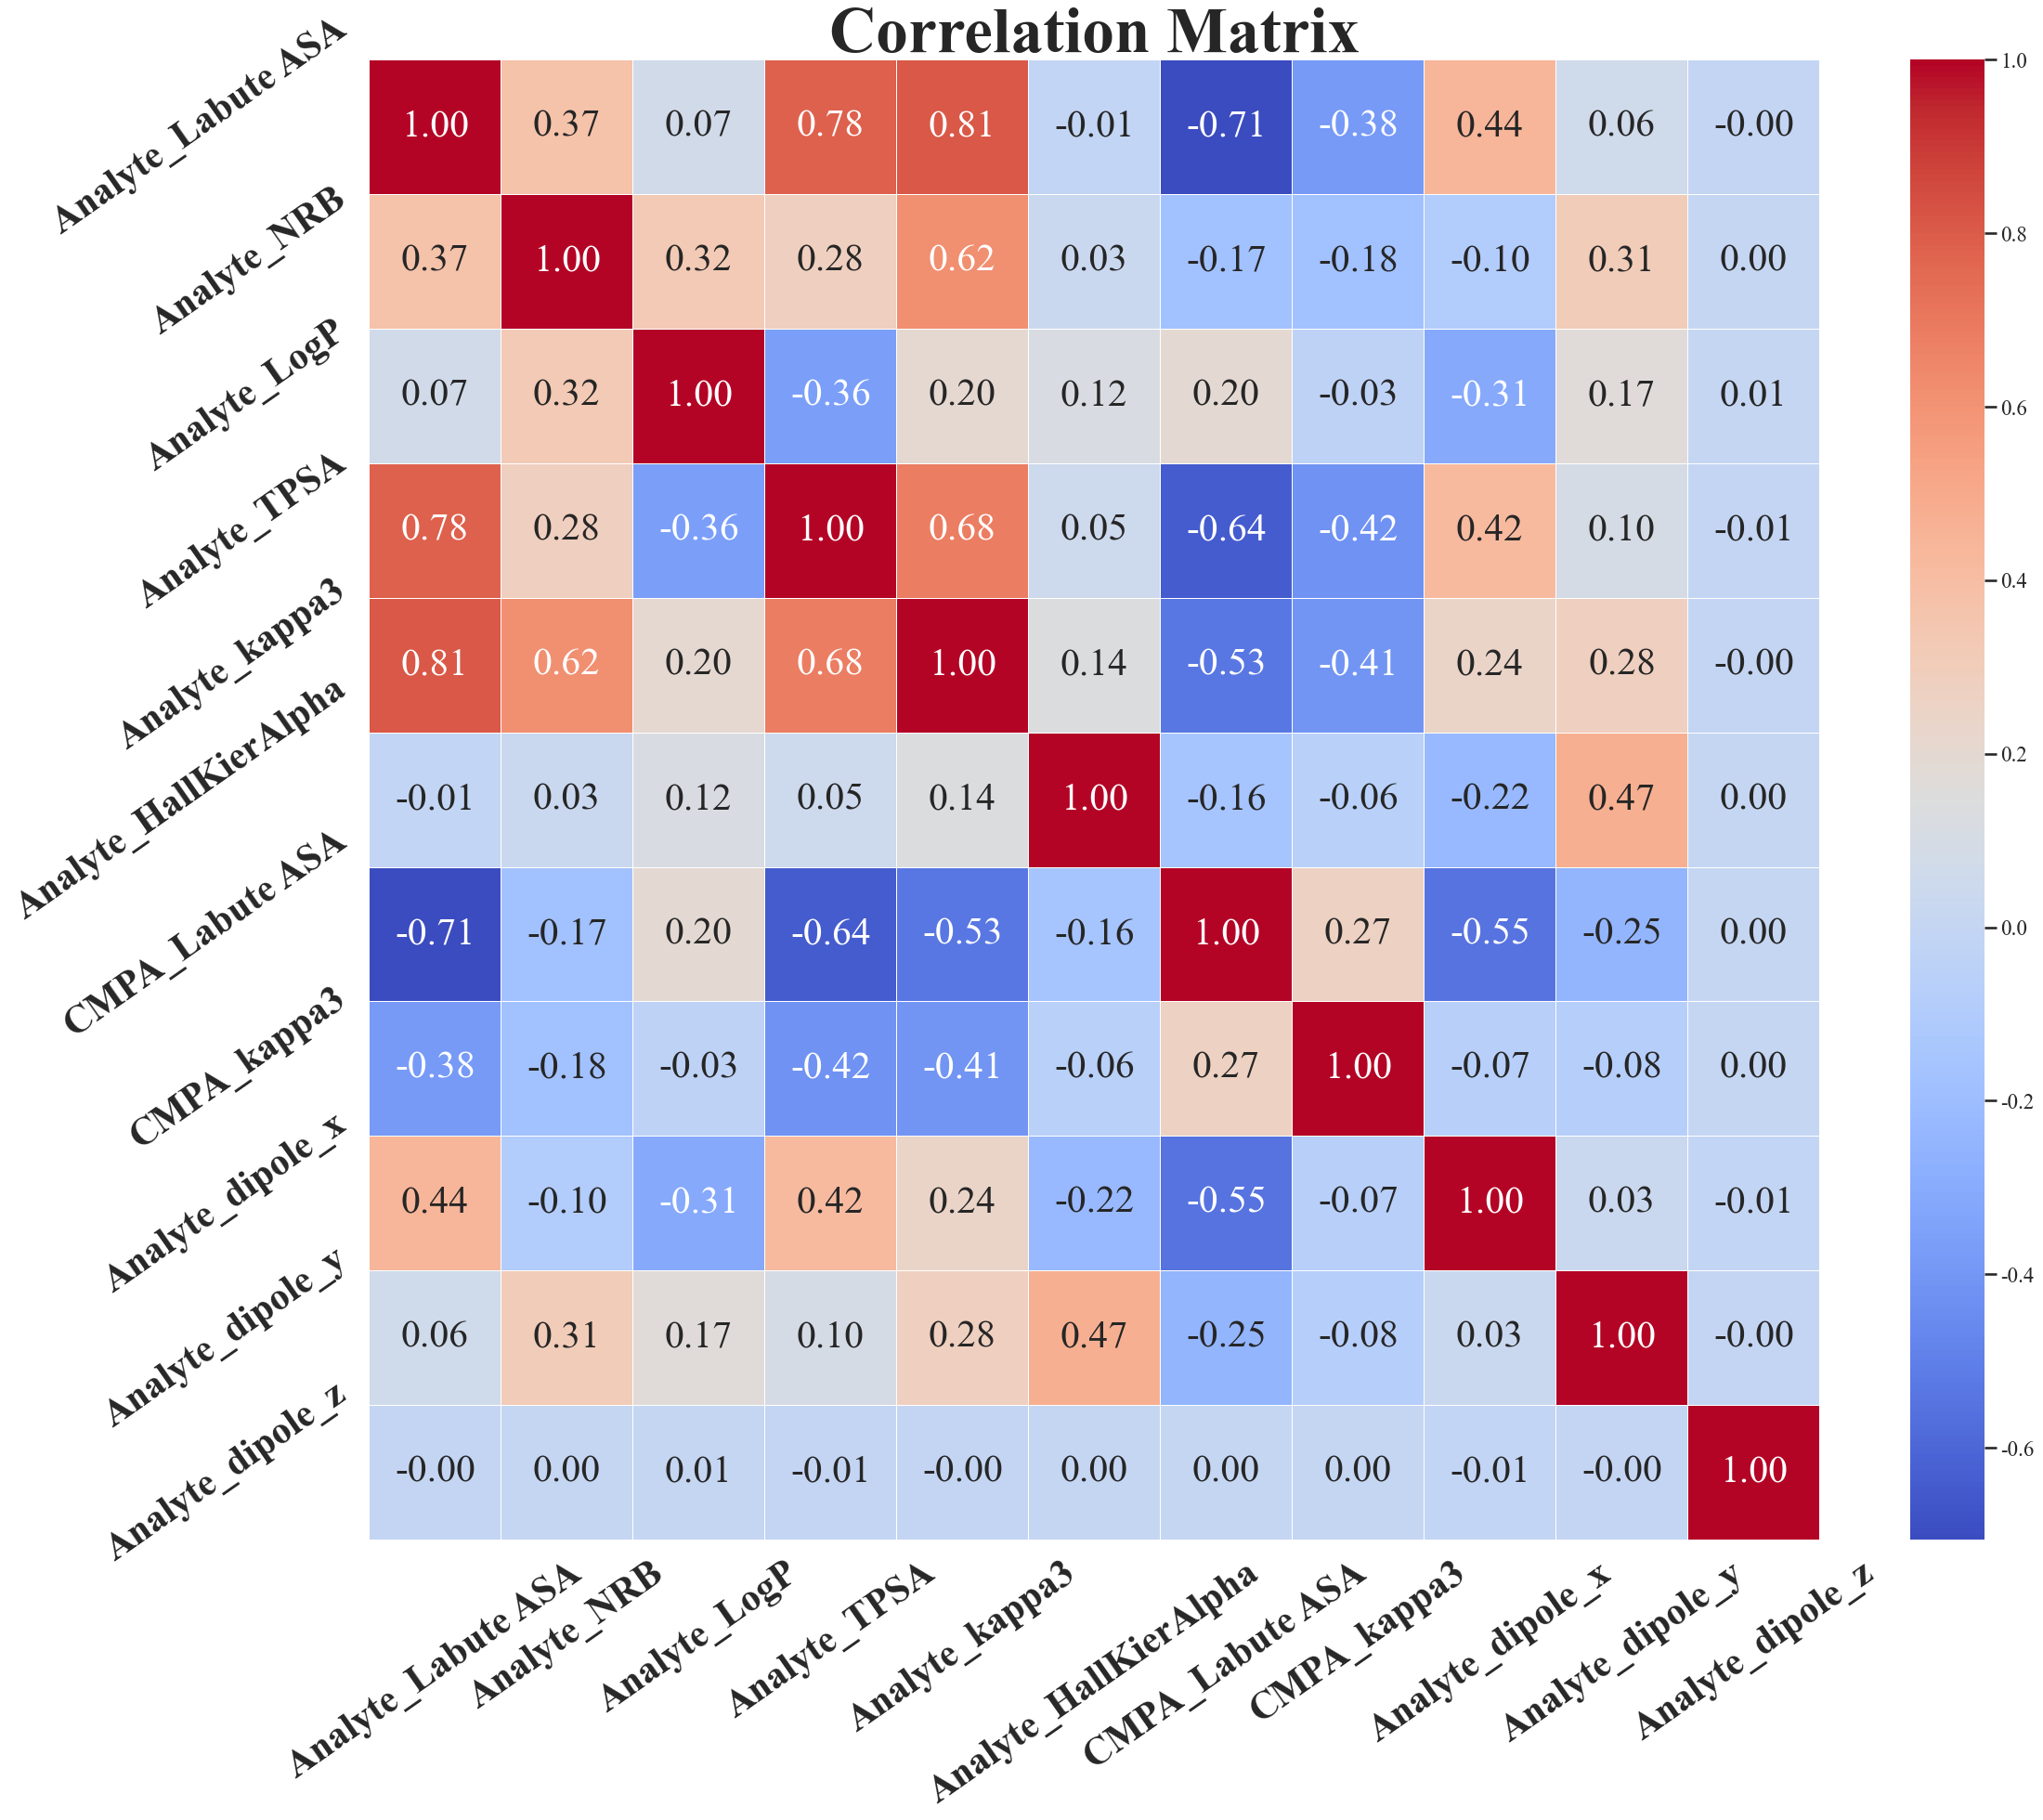

In [409]:
from matplotlib import pyplot as plt
import seaborn as sns
correlation_matrix = X_new.corr()
# 绘制热力图
correlation_matrix_sub = correlation_matrix[[
    # 'Fsp3',
    # 'PBF',
 'Analyte_Labute ASA',
 'Analyte_NRB',
 # 'Analyte_Molecular Weight',
 'Analyte_LogP',
 # 'Analyte_chi0',
 # 'Analyte_kappa1',
 'Analyte_TPSA',
 # 'Analyte_kappa2',
 # 'Analyte_Num Valence Electrons',
 'Analyte_kappa3',
 'Analyte_HallKierAlpha',
 # 'Analyte_chi1',
 'CMPA_Labute ASA',
 # 'CMPA_Number of Rotatable Bonds',
 # 'CMPA_Molecular Weight',
 # 'CMPA_LogP',
 # 'CMPA_chi0',
 # 'CMPA_kappa1',
 # 'CMPA_Topological Polar Surface Area',
 # 'CMPA_kappa2',
 # 'CMPA_Num Valence Electrons',
 'CMPA_kappa3',
 # 'CMPA_HallKierAlpha',
 # 'CMPA_chi1',
 'Analyte_dipole_x',
 'Analyte_dipole_y',
 'Analyte_dipole_z',
 # 'torsion_angle',
 # 'angle0',
 # 'angle1',
 # 'angle2',
 # 'bond0',
 # 'bond1',
 # 'bond2',
 # 'pH',
 # '流速',
 # '柱温',
 # '添加剂用量',
 # '色谱柱',
 # 'column_x',
 # 'column_y',
 # 'solvent_polar'
]]
indexs =[
 'pH',
 # '流速',
 # '柱温',
 # '添加剂用量',
 # '色谱柱',
 # 'column_x',
 # 'column_y',
 'column diameter',
 'column length',
 'flow rate',
 'column temperature',
 'CMPA concentration',
 'packing materials',
 'solvent_polar'
]

correlation_matrix_sub_01 = correlation_matrix_sub.drop(index = indexs)
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来显示正常中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix_sub_01, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5,annot_kws={"size": 30})
plt.title('Correlation Matrix')
plt.yticks(rotation = 35,fontsize = 30, fontweight='bold' )
plt.xticks(rotation = 35,fontsize = 30, fontweight='bold')
plt.title('Correlation Matrix',fontsize = 50, fontweight='bold')
# 使用 tight_layout() 来确保图像居中
plt.tight_layout()
plt.savefig('feature_similar_sub_01.png',dpi=1000)
plt.show()

In [23]:
import shap

k_num = 6

In [ ]:
def object_cat_t1(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 50, 500),
            'depth': trial.suggest_int('depth', 1, 12),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 4e-1),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg',10, 100.0),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
            'random_strength': trial.suggest_int('random_strength', 0, 100),
            'od_type': 'Iter',
            'od_wait': trial.suggest_int('od_wait', 10, 50)
        }
        # 根据bootstrap_type选择相应的参数
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0.0, 10.0)
        elif param['bootstrap_type'] == 'Bernoulli':
            param['subsample'] = trial.suggest_float('subsample', 0.1, 1.0)

        cat_model = CatBoostRegressor(**param)
        kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
        # scores = cross_val_score(xgb_model, X_new, y_new, cv=kf, scoring='neg_mean_squared_error')
        scores = cross_val_score(cat_model, X_new, y_new, cv=kf, scoring='r2')

        return scores.mean()
 #t1预测
study1 = optuna.create_study(direction='maximize')
study1.optimize(object_cat_t1, n_trials=100)


0:	learn: 0.8748301	total: 9.4ms	remaining: 3.75s
1:	learn: 0.8428460	total: 10.2ms	remaining: 2.03s
2:	learn: 0.7966431	total: 11.3ms	remaining: 1.49s
3:	learn: 0.7671942	total: 12.3ms	remaining: 1.22s
4:	learn: 0.7306180	total: 14ms	remaining: 1.11s
5:	learn: 0.7147793	total: 15.4ms	remaining: 1.01s
6:	learn: 0.7084912	total: 16.5ms	remaining: 927ms
7:	learn: 0.7061553	total: 16.9ms	remaining: 830ms
8:	learn: 0.6944416	total: 17.8ms	remaining: 775ms
9:	learn: 0.6654979	total: 19ms	remaining: 741ms
10:	learn: 0.6539916	total: 20.2ms	remaining: 715ms
11:	learn: 0.6337509	total: 21.5ms	remaining: 696ms
12:	learn: 0.6298647	total: 22.6ms	remaining: 672ms
13:	learn: 0.6237766	total: 24.1ms	remaining: 664ms
14:	learn: 0.6190123	total: 25.5ms	remaining: 654ms
15:	learn: 0.6101374	total: 26.9ms	remaining: 646ms
16:	learn: 0.5848134	total: 28.6ms	remaining: 645ms
17:	learn: 0.5827286	total: 29ms	remaining: 616ms
18:	learn: 0.5646982	total: 30.3ms	remaining: 607ms
19:	learn: 0.5581600	total: 3

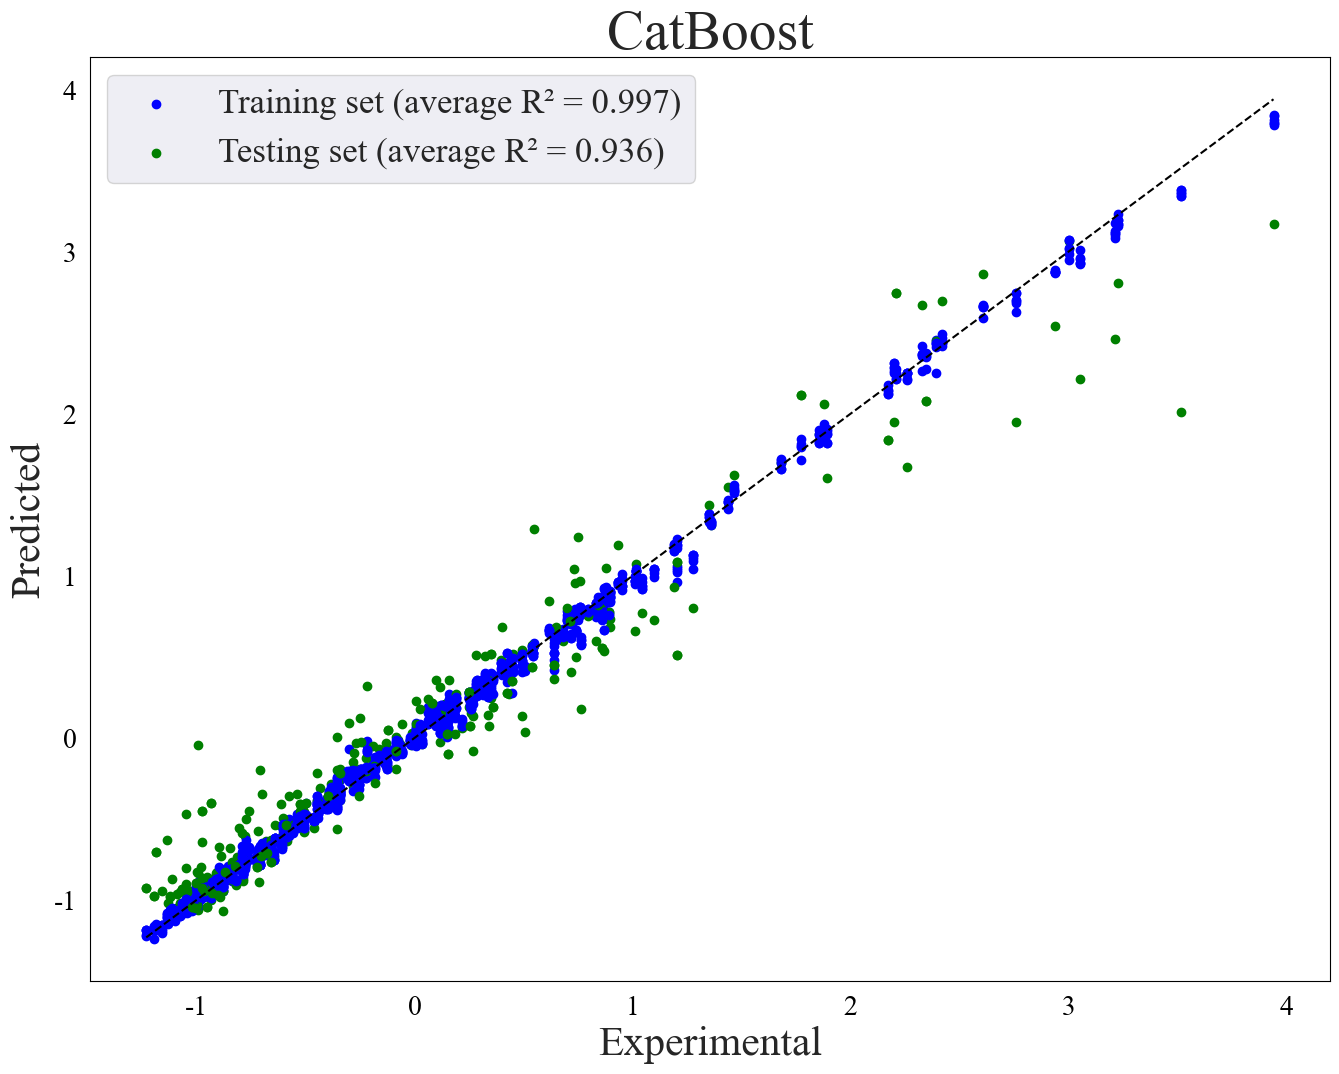

In [58]:
#dingwei
import matplotlib.pyplot as plt
import numpy as np

r2_train_cat = []
r2_test_cat = []
mae_train_cat = []
mae_test_cat = []
mse_train_cat = []
mse_test_cat = []
mape_train_cat = []
mape_test_cat = []
# 用于存储每个样本的预测值
y_test_cat_all = []
y_train_cat_all = []
predictions_cat_all = []
# 存储所有折的SHAP值
all_shap_values = []
all_expected_values = []
all_X_val = []
shap_values_list_cat = []

# 设置全局字体
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
plt.rcParams['font.size'] = 20  # 设置字体大小
plt.figure(figsize=(16, 12),facecolor='none')
fold = 0

# 定义 K 倍验证
kf = KFold(n_splits=k_num ,shuffle=True , random_state=34 )
# 执行 K 倍验证
for idx_train, idx_test in kf.split(X_new):
    predictions_cat = np.zeros(y_new.shape).reshape(-1,1)
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    cat_model = CatBoostRegressor(**study1.best_params)

    cat_model.fit(X_train, y_train)
    # 进行预测
    y_test_pred_t1 = cat_model.predict(X_test)
    y_train_pred_t1 = cat_model.predict(X_train)

    cat_train_t1=r2_score(y_train,y_train_pred_t1)
    cat_test_t1=r2_score(y_test,y_test_pred_t1)
    cat_train_mse=mean_squared_error(y_train,y_train_pred_t1)
    cat_test_mse=mean_squared_error(y_test,y_test_pred_t1)
    cat_train_mae=mean_absolute_error(y_train,y_train_pred_t1)
    cat_test_mae=mean_absolute_error(y_test,y_test_pred_t1)
    cat_train_mape=mean_absolute_percentage_error(y_train,y_train_pred_t1)
    cat_test_mape=mean_absolute_percentage_error(y_test,y_test_pred_t1)
     # 将预测值保存到对应的位置
    predictions_cat[idx_train] = y_train_pred_t1.reshape(-1,1)
    predictions_cat[idx_test] = y_test_pred_t1.reshape(-1,1)
    r2_train_cat.append(cat_train_t1)
    r2_test_cat.append(cat_test_t1)
    mae_train_cat.append(cat_train_mae)
    mae_test_cat.append(cat_test_mae)
    mse_train_cat.append(cat_train_mse)
    mse_test_cat.append(cat_test_mse)
    mape_train_cat.append(cat_train_mape)
    mape_test_cat.append(cat_test_mape)

    y_test_cat_all.extend(y_test)
    y_train_cat_all.extend(y_test_pred_t1)

      # 计算 SHAP 值
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_test)
    shap_values1 = explainer(X_test)
    all_X_val.append(idx_test)
    for SHAPs in shap_values:
        shap_values_list_cat.append(SHAPs)

    predictions_cat_all.append(predictions_cat)
    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred_t1,c = 'b')
    plt.scatter(y_test, y_test_pred_t1,c = 'g')
    # 计算 Spearman 系数和 p 值
    fold +=1

plt.scatter(y_train, y_train_pred_t1,c = 'b', label=f'Training set (average R² = {sum(r2_train_cat) / len(r2_train_cat):.3f})')
plt.scatter(y_test, y_test_pred_t1,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_cat) / len(r2_test_cat):.3f})')

# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')

# 添加图例和标签
plt.grid(False)

plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('CatBoost',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_Cat_01.png',dpi=1000)
# 显示图表
plt.show()

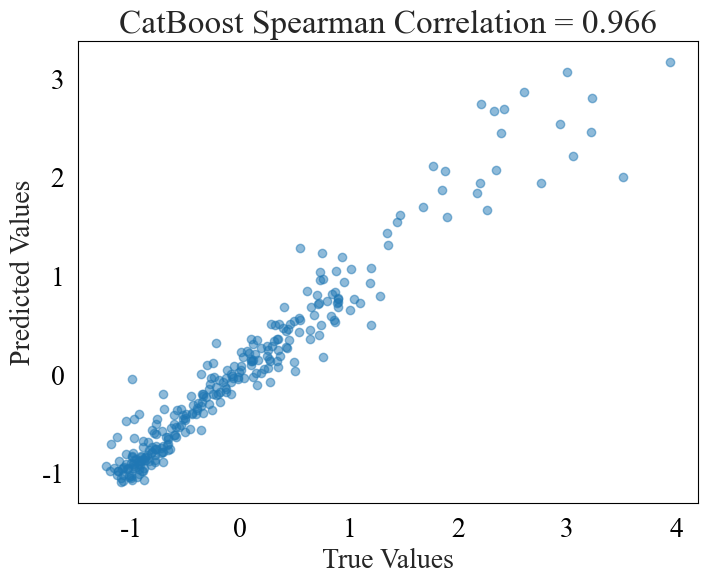

In [75]:
spearman_corr, p_value = spearmanr(y_test_cat_all,y_train_cat_all)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_cat_all,y_train_cat_all, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"CatBoost Spearman Correlation = {spearman_corr:.3f}")
# 获取当前坐标轴
ax = plt.gca()
#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
plt.grid(False)
plt.savefig('Spearman_Cat_01.png',dpi=1000)
plt.show()

In [30]:
X = X_new
X.rename(columns={
    'Analyte_Number of Rotatable Bonds': 'Analyte_NRB',
                   'Analyte_Topological Polar Surface Area': 'Analyte_TPSA',
                   'column_x': 'column diameter',
                   'column_y': 'column length',
                   '流速': 'flow rate',
                   '柱温': 'column temperature',
                   '添加剂用量': 'CMPA concentration',
                   '色谱柱': 'packing materials',
                   }, inplace=True)

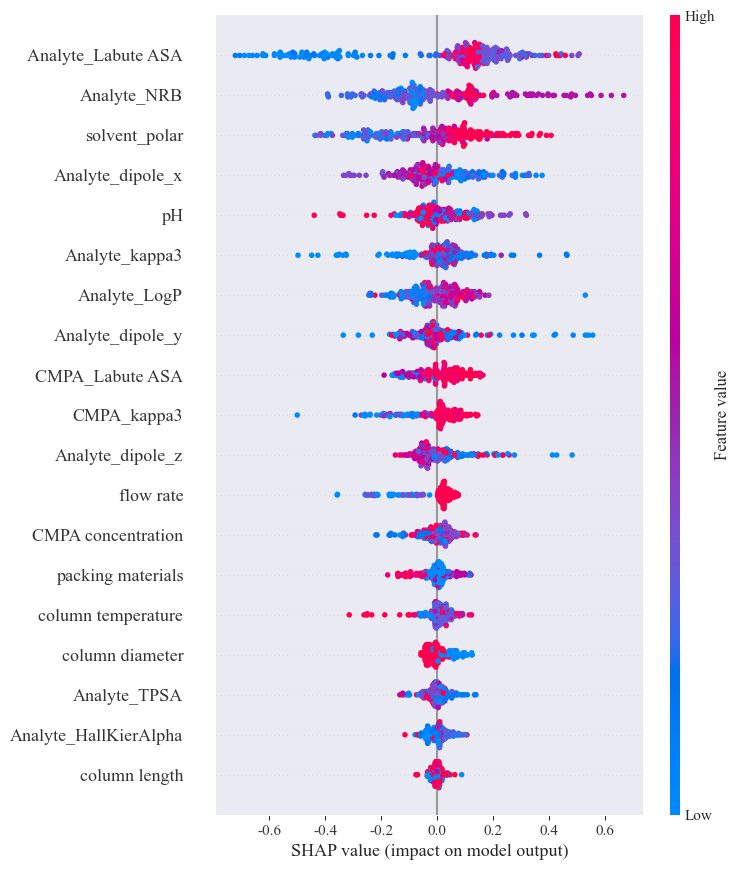

In [31]:
# plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
new_index = [ix for ix_test_fold in all_X_val for ix in ix_test_fold]
shap.summary_plot(np.array(shap_values_list_cat),X.reindex(new_index),show=False)
plt.grid(False)
# plt.savefig('CatBoost_SHAP_value_01.png',dpi = 1000)

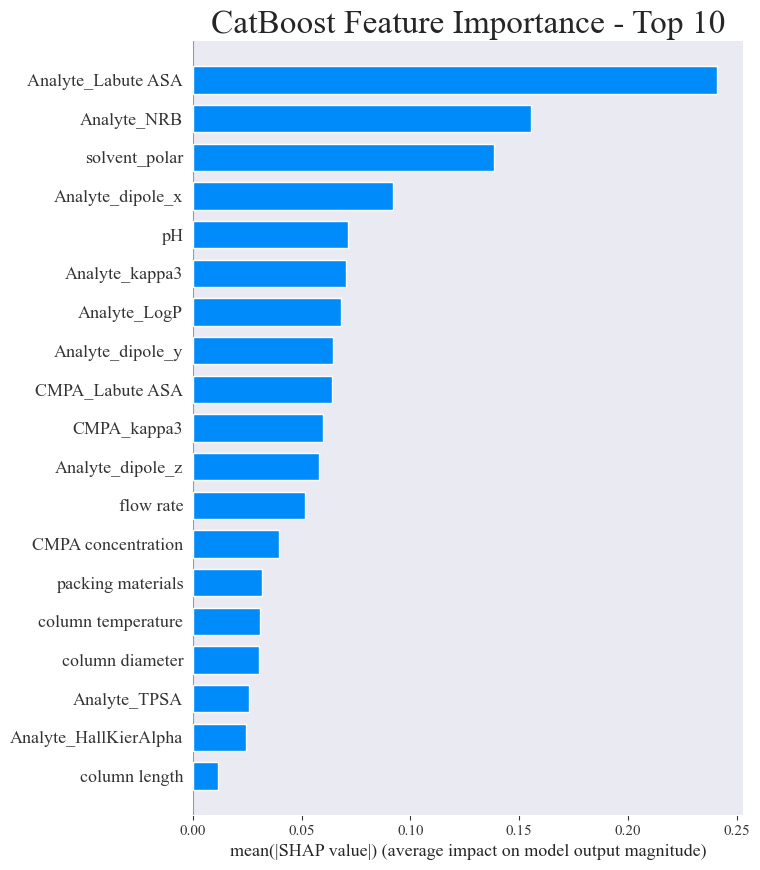

In [33]:
# 提取 SHAP 值和特征名称
shap_values_array = np.array(shap_values_list_cat)
feature_names = X.reindex(new_index).columns
plt.grid(False)
# plt.figure(figsize=(16,6))
# 创建一个 DataFrame 来存储特征的重要性（绝对值的平均）
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': np.abs(shap_values_array).mean(axis=0)  # 计算每个特征的平均绝对 SHAP 值
})

# 对特征按重要性排序并选择前十个
top_features = shap_df.nlargest(19, 'shap_value')

# 绘制前十个特征的条形图
shap.summary_plot(
    shap_values_array[:, top_features.index],
    X.reindex(new_index).iloc[:, top_features.index],
    plot_type="bar",
    show=False
)
plt.title(f'CatBoost Feature Importance - Top 10')
plt.tight_layout()

plt.savefig('CatBoost_SHAP_value_importance_01.png',dpi = 1000)

In [262]:
# 定义目标函数
def objective(trial):
    # 设定XGBoost的超参数
    param = {
         'objective': 'reg:squarederror',  # 回归任务
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),

        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-5, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1.0),
        'n_estimators': 100,  # 固定树的数量
        'tree_method': 'gpu_hist',  # 启用 GPU 训练
    }

    xgb_model = XGBRegressor(**param)
    kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
    # scores = cross_val_score(xgb_model, X_new, y_new, cv=kf, scoring='neg_mean_absolute_error')
    scores = cross_val_score(xgb_model, X_new, y_new, cv=kf, scoring='r2')

    return scores.mean()

study2 = optuna.create_study(direction='maximize')  # 最大化准确率
study2.optimize(objective, n_trials=100)


[I 2025-02-21 23:40:19,933] A new study created in memory with name: no-name-dc8d6977-aa1c-4bf7-bd40-b18eb18bf245
C:\Users\re\AppData\Local\Temp\ipykernel_28416\4198146122.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
C:\Users\re\AppData\Local\Temp\ipykernel_28416\4198146122.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\re\AppData\Local\Temp\ipykernel_28416\4198146122.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use su

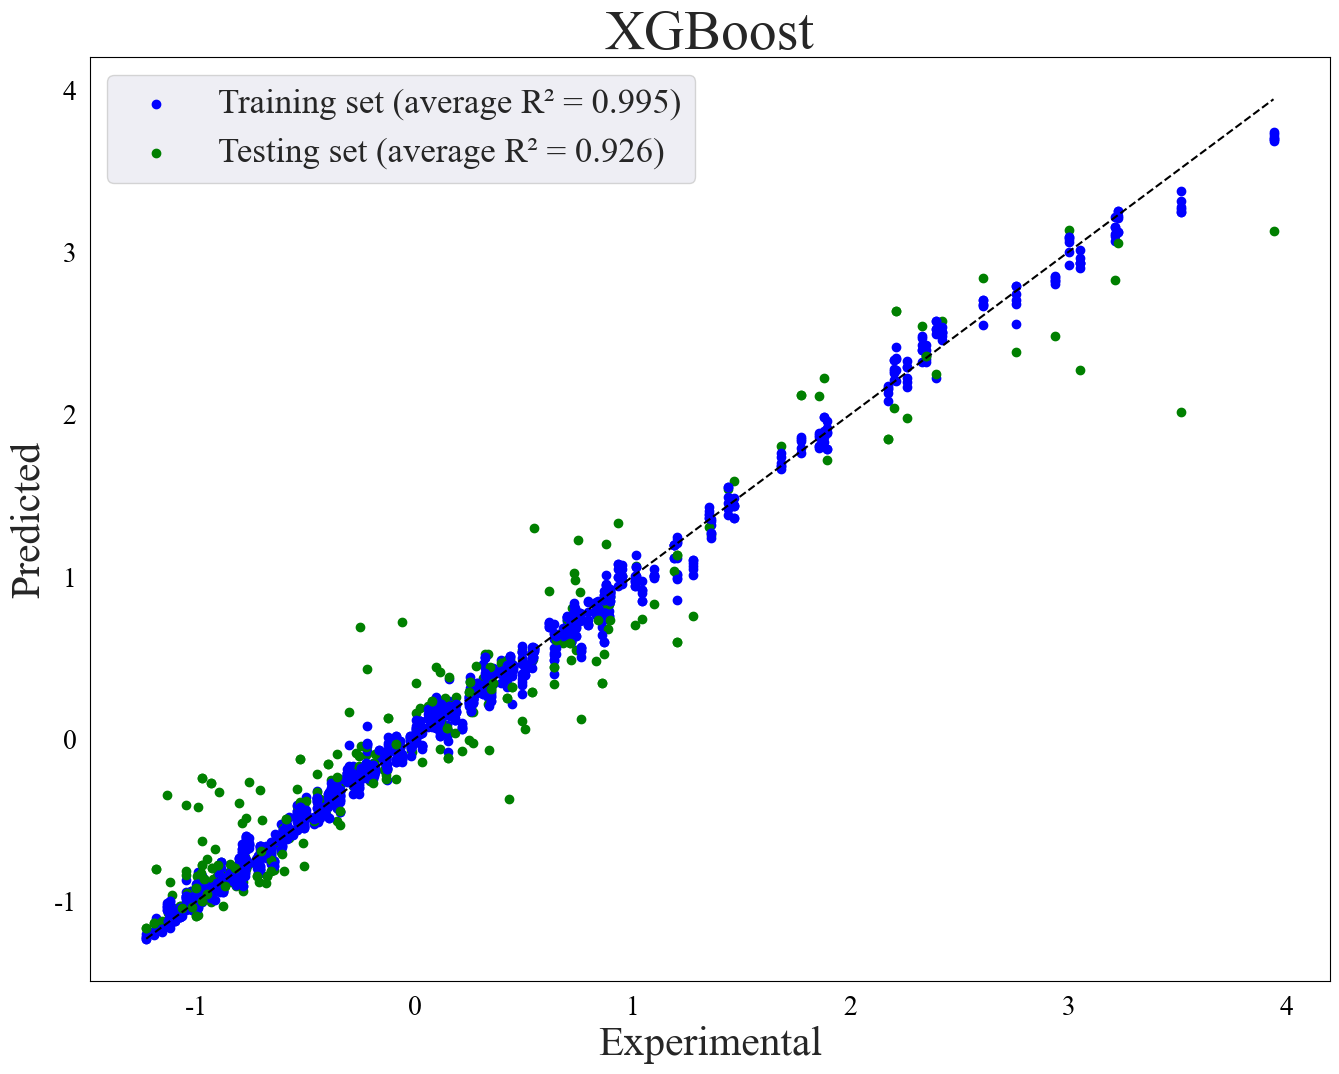

In [56]:
#dingwei
r2_train_xgb = []
r2_test_xgb = []
mae_train_xgb = []
mae_test_xgb = []
mse_train_xgb = []
mse_test_xgb = []
mape_train_xgb = []
mape_test_xgb = []
# 用于存储每个样本的预测值
y_test_xgb_all = []
y_train_xgb_all = []
predictions_xgb_all = []
# 存储所有折的SHAP值
all_shap_values = []
all_expected_values = []
all_X_val = []
shap_values_list_xgb = []
fold = 0

plt.figure(figsize=(16, 12),facecolor='none')
# 设置全局字体
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
plt.rcParams['font.size'] = 10  # 设置字体大小



kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
# 执行 K 倍验证
for idx_train, idx_test in kf.split(X_new):

    predictions_xgb = np.zeros(y_new.shape).reshape(-1,1)
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    xgb_model=XGBRegressor(**study2.best_params)

    xgb_model.fit(X_train, y_train)
    y_test_pred1= xgb_model.predict(X_test)
    y_train_pred1= xgb_model.predict(X_train)
    xgb_train_r2=r2_score(y_train,y_train_pred1)
    xgb_test_r2=r2_score(y_test,y_test_pred1)
    xgb_train_mae=mean_absolute_error(y_train, y_train_pred1)
    xgb_test_mae=mean_absolute_error(y_test, y_test_pred1)
    xgb_train_mse=mean_squared_error(y_train, y_train_pred1)
    xgb_test_mse=mean_squared_error(y_test, y_test_pred1)
    xgb_train_mape=mean_absolute_percentage_error(y_train,y_train_pred1)
    xgb_test_mape=mean_absolute_percentage_error(y_test,y_test_pred1)

    mape_train_xgb.append(xgb_train_mape)
    mape_test_xgb.append(xgb_test_mape)
     # 将预测值保存到对应的位置
    predictions_xgb[idx_train] = y_train_pred1.reshape(-1,1)
    predictions_xgb[idx_test] = y_test_pred1.reshape(-1,1)
    r2_train_xgb.append(xgb_train_r2)
    r2_test_xgb.append(xgb_test_r2)
    mae_train_xgb.append(xgb_train_mae)
    mae_test_xgb.append(xgb_test_mae)
    mse_train_xgb.append(xgb_train_mse)
    mse_test_xgb.append(xgb_test_mse)

    predictions_xgb_all.append(predictions_xgb)

    y_test_xgb_all.extend(y_test)
    y_train_xgb_all.extend(y_test_pred1)

      # 计算 SHAP 值
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test)
    shap_values1 = explainer(X_test)
    all_X_val.append(idx_test)
    for SHAPs in shap_values:
        shap_values_list_xgb.append(SHAPs)

    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred1,c = 'b')
    plt.scatter(y_test, y_test_pred1,c = 'g')
    fold +=1

plt.scatter(y_train, y_train_pred1,c = 'b', label=f'Training set (average R² = {sum(r2_train_xgb) / len(r2_train_xgb):.3f})')
plt.scatter(y_test, y_test_pred1,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_xgb) / len(r2_test_xgb):.3f})')

# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
# 添加图例和标签
plt.grid(False)
plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('XGBoost',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_XGB_01.png',dpi=1000)
# 显示图表
plt.show()

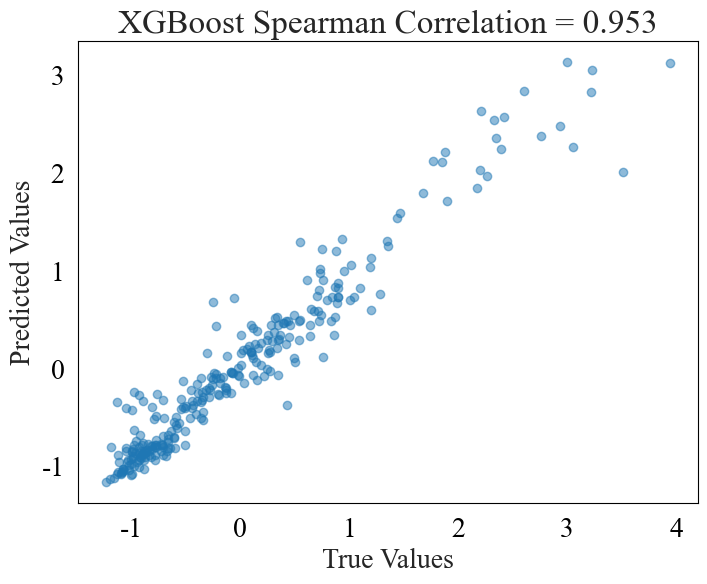

In [76]:
spearman_corr, p_value = spearmanr(y_test_xgb_all,y_train_xgb_all)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_xgb_all,y_train_xgb_all, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"XGBoost Spearman Correlation = {spearman_corr:.3f}")
# 获取当前坐标轴
ax = plt.gca()
#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
plt.grid(False)

plt.savefig('Spearman_xgb_01.png',dpi=1000)
plt.show()

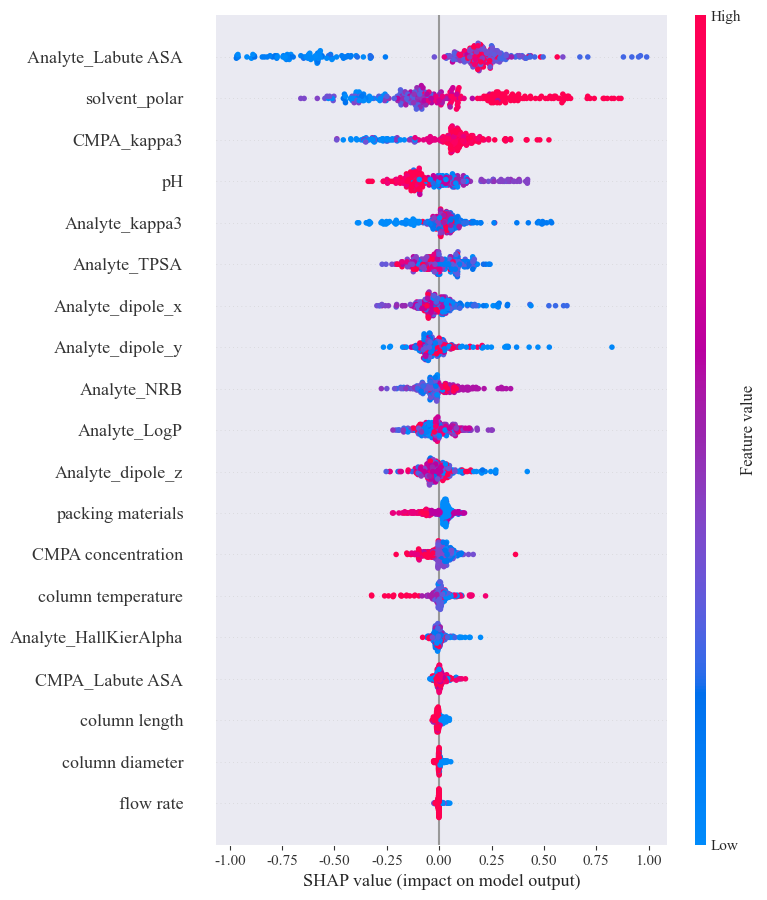

In [431]:
# plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False # 显示负号
new_index = [ix for ix_test_fold in all_X_val for ix in ix_test_fold]
shap.summary_plot(np.array(shap_values_list_xgb),X.reindex(new_index),show=False)
plt.grid(False)
# plt.savefig('XGBoost_SHAP_value_01.png',dpi = 1000)

In [265]:
# 定义目标函数
def objective_lgb(trial):
    # 选择超参数
    param = {
        'objective': 'regression',
        'metric': 'mse',
        'boosting_type': 'gbdt',  # 可以选择 gbdt, dart, 等
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 50),  # -1 表示无限制
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'device': 'gpu',              # 启用 GPU
        'gpu_device_id': 0,           # 使用第一个 GPU
    }

    # 创建 LGBMRegressor 模型
    lgb_model = LGBMRegressor(**param)
    kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
    # scores = cross_val_score(xgb_model, X_new, y_new, cv=kf, scoring='neg_mean_absolute_error')
    scores = cross_val_score(lgb_model, X_new, y_new, cv=kf, scoring='r2')
    return scores.mean()

study_lgb = optuna.create_study(direction='maximize')  # 最大化准确率
study_lgb.optimize(objective_lgb, n_trials=100)


[I 2025-02-21 23:45:27,653] A new study created in memory with name: no-name-36a40249-b039-4e44-bae1-c91294e91fb6
C:\Users\re\AppData\Local\Temp\ipykernel_28416\3847193307.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\re\.conda\envs\py310\lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\re\.conda\envs\py310\lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\re\.conda\envs\py310\lib\site-packages\lightgbm\basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")
C:\Users\re\.co

In [ ]:
#dingwei
r2_train_lgb = []
r2_test_lgb = []
mae_train_lgb = []
mae_test_lgb = []
mse_train_lgb = []
mse_test_lgb = []
mape_train_lgb = []
mape_test_lgb = []
# 用于存储每个样本的预测值
y_test_lgb_all = []
y_train_lgb_all = []
predictions_lgb_all = []

# 存储所有折的SHAP值
all_shap_values = []
all_expected_values = []
all_X_val = []
shap_values_list_lgb = []
fold = 0

plt.figure(figsize=(16, 12),facecolor='none')

kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
for idx_train, idx_test in kf.split(X_new):

    predictions_lgb = np.zeros(y_new.shape).reshape(-1,1)
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    lgb_model=LGBMRegressor(**study_lgb.best_params)
    lgb_model.fit(X_train, y_train)
    y_test_pred2 = lgb_model.predict(X_test)
    y_train_pred2 = lgb_model.predict(X_train)
    lgb_train_r2=r2_score(y_train,y_train_pred2)
    lgb_test_r2=r2_score(y_test,y_test_pred2)
    lgb_train_mae=mean_absolute_error(y_train, y_train_pred2)
    lgb_test_mae=mean_absolute_error(y_test, y_test_pred2)
    lgb_train_mse=mean_squared_error(y_train, y_train_pred2)
    lgb_test_mse=mean_squared_error(y_test, y_test_pred2)
    lgb_train_mape=mean_absolute_percentage_error(y_train,y_train_pred2)
    lgb_test_mape=mean_absolute_percentage_error(y_test,y_test_pred2)

    mape_train_lgb.append(lgb_train_mape)
    mape_test_lgb.append(lgb_test_mape)
    # 将预测值保存到对应的位置
    predictions_lgb[idx_train] = y_train_pred2.reshape(-1,1)
    predictions_lgb[idx_test] = y_test_pred2.reshape(-1,1)
    r2_train_lgb.append(lgb_train_r2)
    r2_test_lgb.append(lgb_test_r2)
    mae_train_lgb.append(lgb_train_mae)
    mae_test_lgb.append(lgb_test_mae)
    mse_train_lgb.append(lgb_train_mse)
    mse_test_lgb.append(lgb_test_mse)

    predictions_lgb_all.append(predictions_lgb)

    y_test_lgb_all.extend(y_test)
    y_train_lgb_all.extend(y_test_pred2)
      # 计算 SHAP 值
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_test)
    shap_values1 = explainer(X_test)
    all_X_val.append(idx_test)
    for SHAPs in shap_values:
        shap_values_list_lgb.append(SHAPs)

    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred2,c = 'b')
    plt.scatter(y_test, y_test_pred2,c = 'g')
    fold +=1


plt.scatter(y_train, y_train_pred2,c = 'b', label=f'Training set (average R² = {sum(r2_train_lgb) / len(r2_train_lgb):.3f})')
plt.scatter(y_test, y_test_pred2,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_lgb) / len(r2_test_lgb):.3f})')
# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
# 添加图例和标签
plt.grid(False)
plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('LGBM',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_LGB_01.png',dpi=1000)
# 显示图表
plt.show()


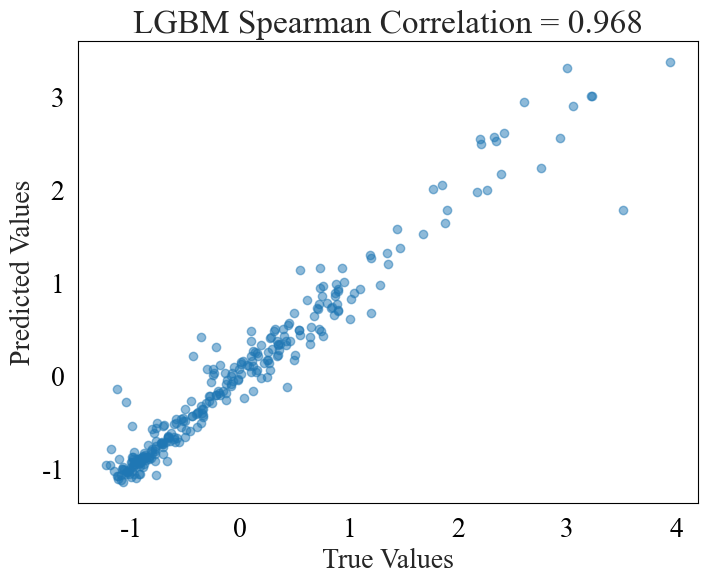

In [77]:
spearman_corr, p_value = spearmanr(y_test_lgb_all,y_train_lgb_all)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_lgb_all,y_train_lgb_all, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"LGBM Spearman Correlation = {spearman_corr:.3f}")
# 获取当前坐标轴
ax = plt.gca()
#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
plt.grid(False)
plt.savefig('Spearman_lgb_01.png',dpi=1000)
plt.show()

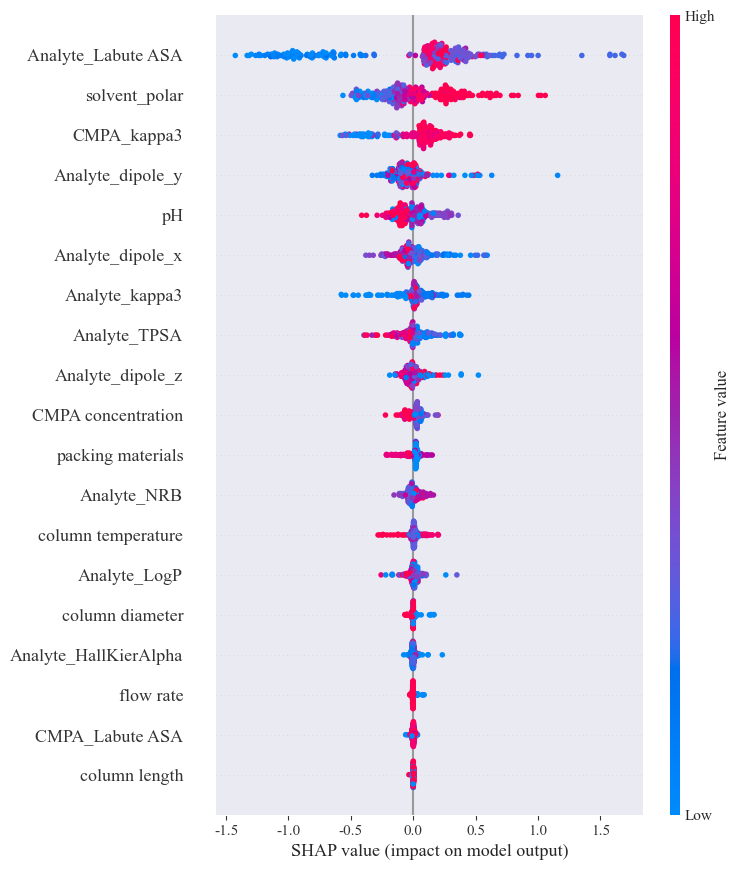

In [36]:
# plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False # 显示负号
new_index = [ix for ix_test_fold in all_X_val for ix in ix_test_fold]
shap.summary_plot(np.array(shap_values_list_lgb),X.reindex(new_index),show=False)
plt.grid(False)
plt.savefig('LGBM_SHAP_value_01.png',dpi = 1000)

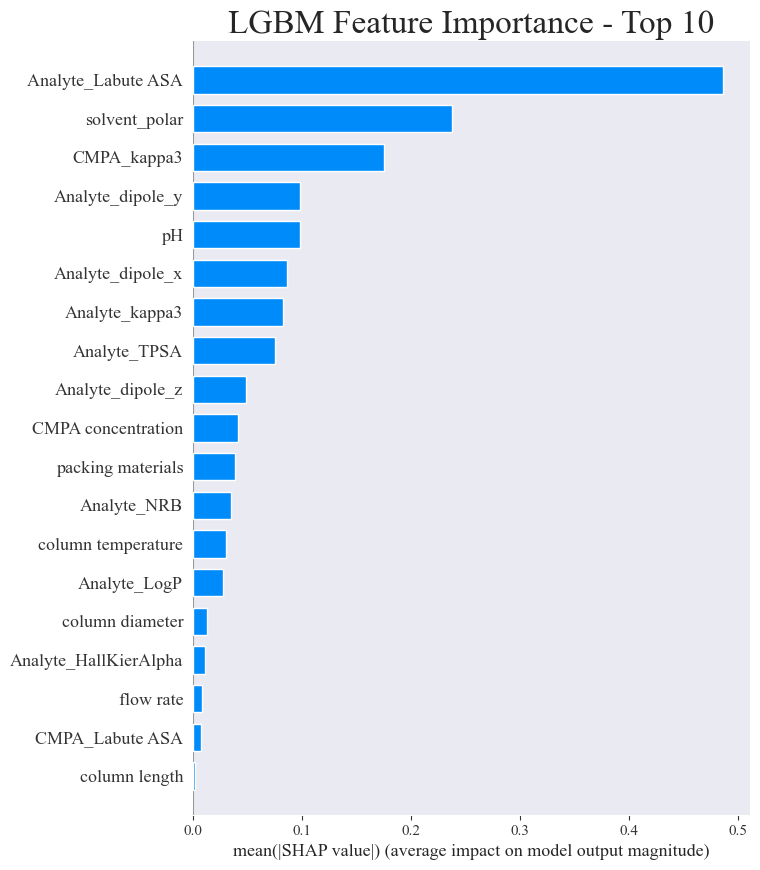

In [37]:
# 提取 SHAP 值和特征名称
shap_values_array = np.array(shap_values_list_lgb)
feature_names = X.reindex(new_index).columns
plt.grid(False)
# plt.figure(figsize=(16,6))
# 创建一个 DataFrame 来存储特征的重要性（绝对值的平均）
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': np.abs(shap_values_array).mean(axis=0)  # 计算每个特征的平均绝对 SHAP 值
})

# 对特征按重要性排序并选择前十个
top_features = shap_df.nlargest(19, 'shap_value')

# 绘制前十个特征的条形图
shap.summary_plot(
    shap_values_array[:, top_features.index],
    X.reindex(new_index).iloc[:, top_features.index],
    plot_type="bar",
    show=False
)
plt.title(f'LGBM Feature Importance - Top 10')
plt.tight_layout()

plt.savefig('LGBM_SHAP_value_importance_01.png',dpi = 1000)

In [269]:
# 定义目标函数
def objective_gb(trial):
    # 选择超参数
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    }

    # 创建 GradientBoostingRegressor 模型
    gb_model = GradientBoostingRegressor(**param)
    kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
    # scores = cross_val_score(gb_model, X_new, y_new, cv=kf, scoring='neg_mean_absolute_error')
    scores = cross_val_score(gb_model, X_new, y_new, cv=kf, scoring='r2')
    return scores.mean()

study_gb = optuna.create_study(direction='maximize')  # 最大化准确率
study_gb.optimize(objective_gb, n_trials=100)


[I 2025-02-22 00:06:33,481] A new study created in memory with name: no-name-5e3d2628-a904-40c2-893f-50b1c91de430
C:\Users\re\AppData\Local\Temp\ipykernel_28416\104152766.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 0.1),
C:\Users\re\AppData\Local\Temp\ipykernel_28416\104152766.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

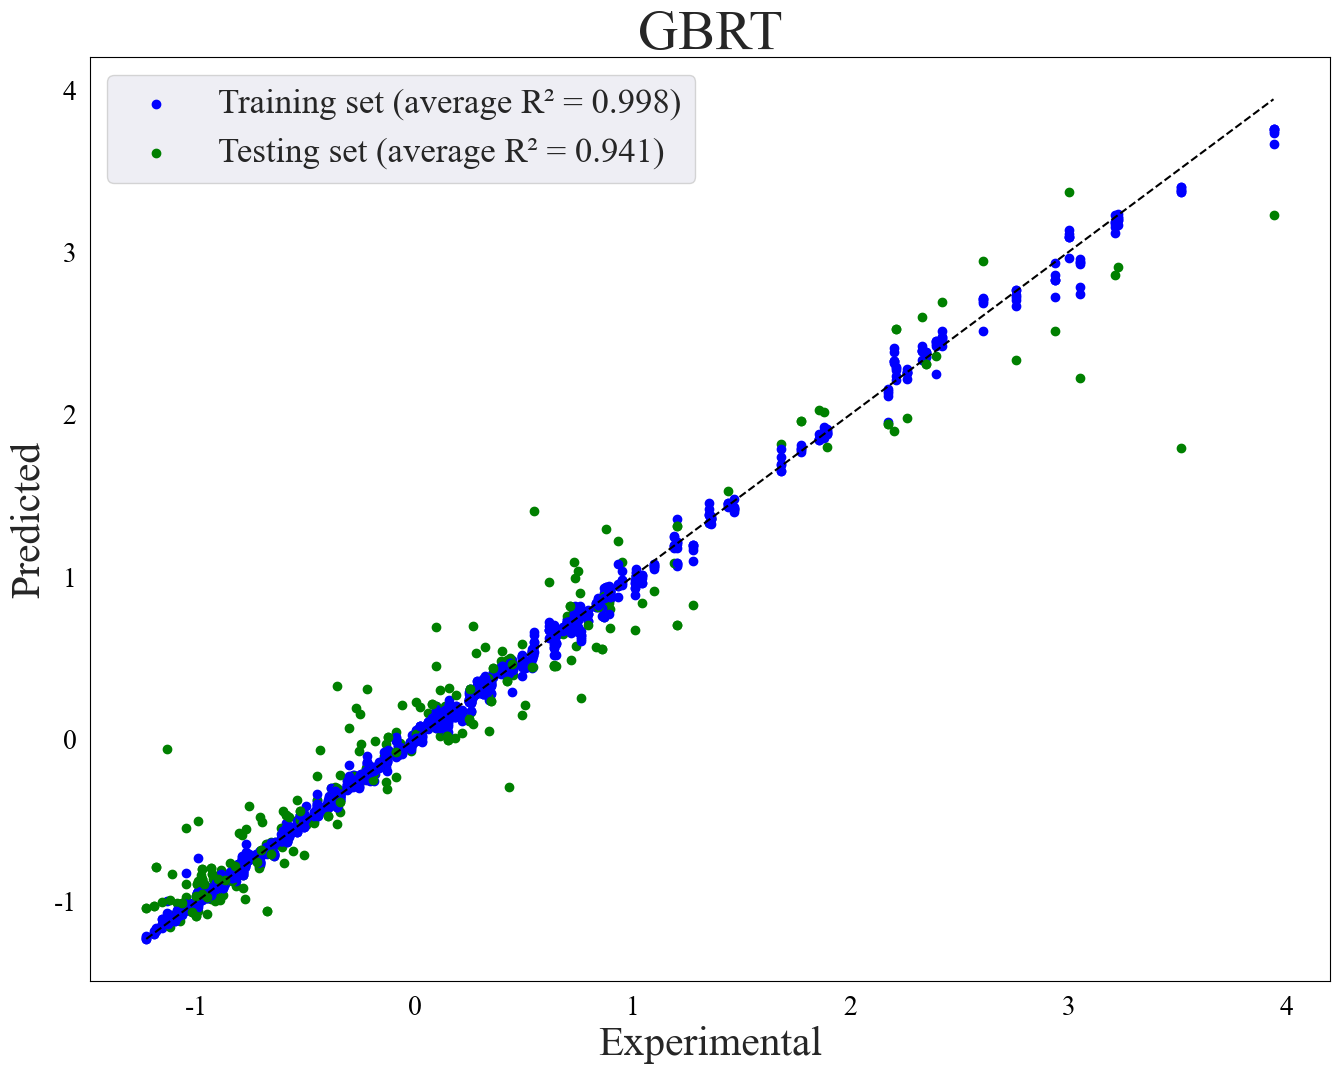

In [69]:
#dingwei
r2_train_gb = []
r2_test_gb = []
mae_train_gb = []
mae_test_gb = []
mse_train_gb = []
mse_test_gb = []
mape_train_gb = []
mape_test_gb = []
# 用于存储每个样本的预测值
y_test_gb_all = []
y_train_gb_all = []
predictions_gb_all = []

# 存储所有折的SHAP值
all_shap_values = []
all_expected_values = []
all_X_val = []
shap_values_list_gb = []
fold = 0

plt.figure(figsize=(16, 12),facecolor='none')


kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
for idx_train, idx_test in kf.split(X_new):
    predictions_gb = np.zeros(y_new.shape).reshape(-1,1)
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

# 梯度提升回归器
    gb_model = GradientBoostingRegressor(**study_gb.best_params)

    gb_model.fit(X_train, y_train)
    y_test_pred_gb = gb_model.predict(X_test)
    y_train_pred_gb = gb_model.predict(X_train)
    gb_train_mse=mean_squared_error(y_train,y_train_pred_gb)
    gb_test_mse=mean_squared_error(y_test,y_test_pred_gb)
    gb_train_r2 = r2_score(y_train, y_train_pred_gb)
    gb_test_r2 = r2_score(y_test, y_test_pred_gb)
    gb_train_mae=mean_absolute_error(y_train, y_train_pred_gb)
    gb_test_mae=mean_absolute_error(y_test, y_test_pred_gb)
    gb_train_mape=mean_absolute_percentage_error(y_train,y_train_pred_gb)
    gb_test_mape=mean_absolute_percentage_error(y_test,y_test_pred_gb)

    mape_train_gb.append(gb_train_mape)
    mape_test_gb.append(gb_test_mape)
     # 将预测值保存到对应的位置
    predictions_gb[idx_train] = y_train_pred_gb.reshape(-1,1)
    predictions_gb[idx_test] = y_test_pred_gb.reshape(-1,1)
    r2_train_gb.append(gb_train_r2)
    r2_test_gb.append(gb_test_r2)
    mae_train_gb.append(gb_train_mae)
    mae_test_gb.append(gb_test_mae)
    mse_train_gb.append(gb_train_mse)
    mse_test_gb.append(gb_test_mse)

    predictions_gb_all.append(predictions_gb)

    y_test_gb_all.extend(y_test)
    y_train_gb_all.extend(y_test_pred_gb)

      # 计算 SHAP 值
    explainer = shap.TreeExplainer(gb_model)
    shap_values = explainer.shap_values(X_test)
    shap_values1 = explainer(X_test)
    all_X_val.append(idx_test)
    for SHAPs in shap_values:
        shap_values_list_gb.append(SHAPs)

    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred_gb,c = 'b')
    plt.scatter(y_test, y_test_pred_gb ,c = 'g')
    fold +=1

plt.scatter(y_train, y_train_pred_gb,c = 'b', label=f'Training set (average R² = {sum(r2_train_gb) / len(r2_train_gb):.3f})')
plt.scatter(y_test, y_test_pred_gb,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_gb) / len(r2_test_gb):.3f})')
# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
# 添加图例和标签
plt.grid(False)
plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('GBRT',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_GB_01.png',dpi=1000)
# 显示图表
plt.show()


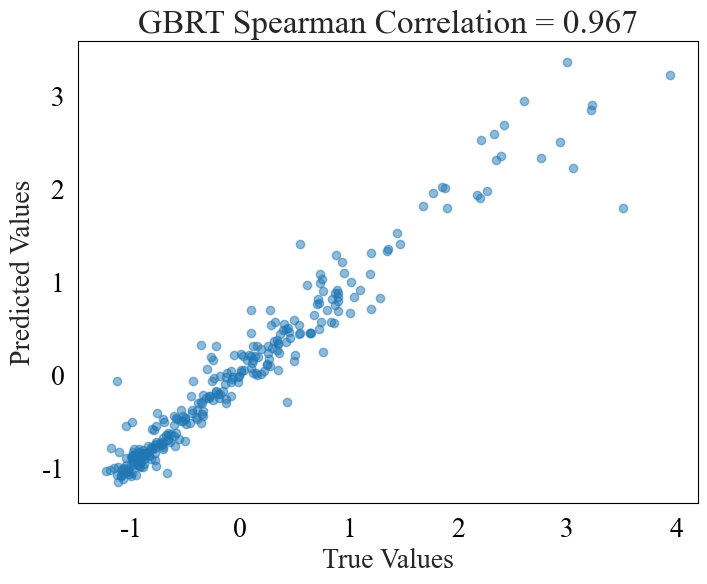

In [78]:
spearman_corr, p_value = spearmanr(y_test_gb_all,y_train_gb_all)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_gb_all,y_train_gb_all, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"GBRT Spearman Correlation = {spearman_corr:.3f}")
# 获取当前坐标轴
ax = plt.gca()
#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
plt.grid(False)

plt.savefig('Spearman_gb_01.png',dpi=1000)
plt.show()

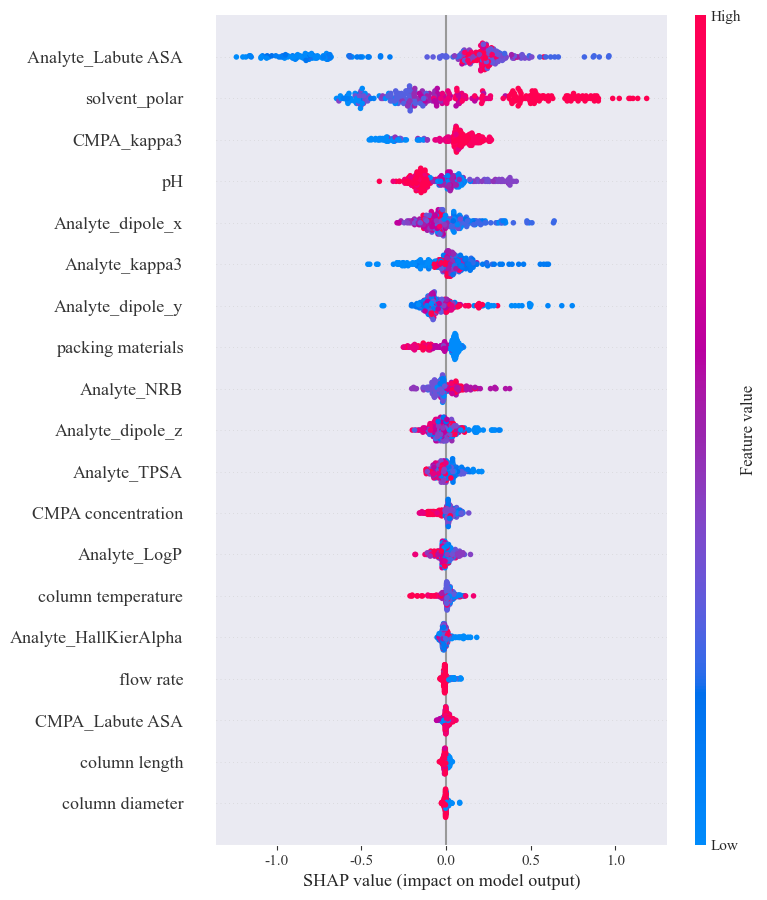

In [446]:
# plt.figure(figsize=(5, 4))
plt.rcParams['font.family'] = 'serif'  # 设置字体类型，例如 'serif', 'sans-serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 指定具体的 serif 字体
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False # 显示负号
new_index = [ix for ix_test_fold in all_X_val for ix in ix_test_fold]
shap.summary_plot(np.array(shap_values_list_gb),X.reindex(new_index),show=False)
plt.grid(False)
# plt.savefig('XGBoost_SHAP_value_01.png',dpi = 1000)

In [272]:
from sklearn.svm import SVR

def objective_svr(trial):
    # 定义超参数搜索空间
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    epsilon = trial.suggest_uniform('epsilon', 0, 1)
    # 创建 SVR 模型
    svr_model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
    # # 训练模型
    kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
    # scores = cross_val_score(svr_model, X_new, y_new, cv=kf, scoring='neg_mean_squared_error')
    scores = cross_val_score(svr_model, X_new, y_new, cv=kf, scoring='r2')
    return scores.mean()

study_svr = optuna.create_study(direction='maximize')
study_svr.optimize(objective_svr, n_trials=100)


[I 2025-02-22 00:11:07,356] A new study created in memory with name: no-name-84c0de72-e61d-43ef-b1ec-bef50c85a171
C:\Users\re\AppData\Local\Temp\ipykernel_28416\2311473500.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
C:\Users\re\AppData\Local\Temp\ipykernel_28416\2311473500.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform('epsilon', 0, 1)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\re\.conda\envs\py310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

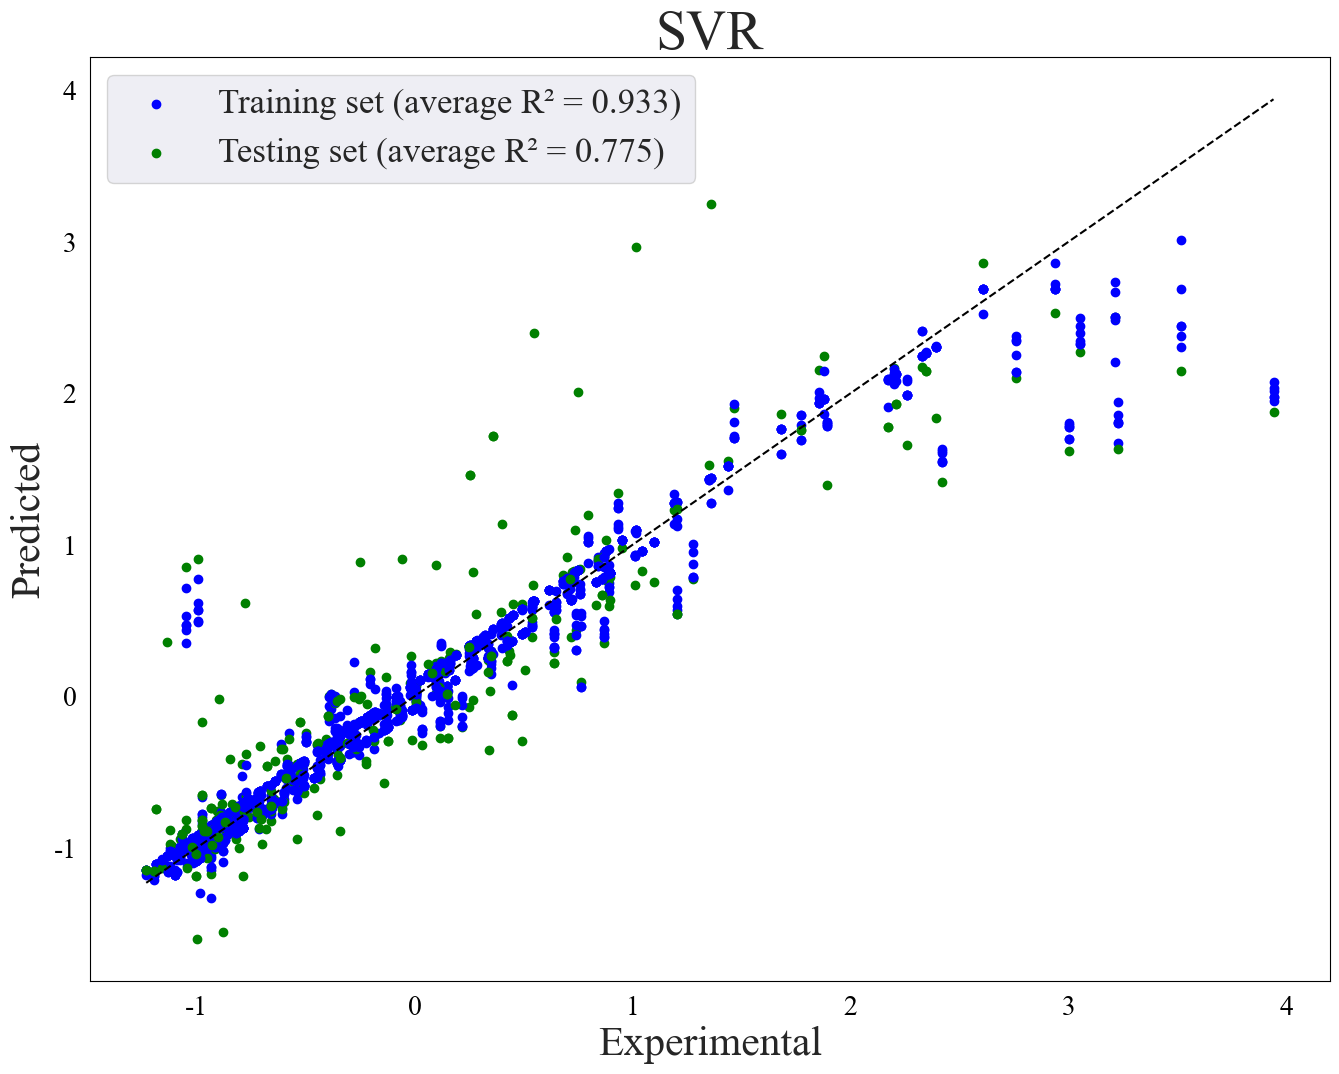

In [36]:
#dingwei
r2_train_SVR = []
r2_test_SVR = []
mae_train_SVR = []
mae_test_SVR = []
mse_train_SVR = []
mse_test_SVR = []
mape_train_SVR = []
mape_test_SVR = []
# 用于存储每个样本的预测值
y_test_SVR_all = []
y_train_SVR_all = []
predictions_SVR = np.zeros(y_new.shape).reshape(-1,1)
plt.figure(figsize=(16, 12),facecolor='none')
kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
for idx_train, idx_test in kf.split(X_new):
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    # 使用 Optuna 进行优化
    SVR_model=SVR(**study_svr.best_params)
    SVR_model.fit(X_train, y_train)
    y_test_pred_SVR= SVR_model.predict(X_test)
    y_train_pred_SVR= SVR_model.predict(X_train)
    SVR_train_r2=r2_score(y_train,y_train_pred_SVR)
    SVR_test_r2=r2_score(y_test,y_test_pred_SVR)
    SVR_train_mae=mean_absolute_error(y_train, y_train_pred_SVR)
    SVR_test_mae=mean_absolute_error(y_test, y_test_pred_SVR)
    SVR_train_mse=mean_squared_error(y_train, y_train_pred_SVR)
    SVR_test_mse=mean_squared_error(y_test, y_test_pred_SVR)
    SVR_train_mape=mean_absolute_percentage_error(y_train,y_train_pred_SVR)
    SVR_test_mape=mean_absolute_percentage_error(y_test,y_test_pred_SVR)

    mape_train_SVR.append(SVR_train_mape)
    mape_test_SVR.append(SVR_test_mape)
     # 将预测值保存到对应的位置
    # predictions[idx_train] = y_train_pred1.reshape(-1,1)
    predictions_SVR[idx_test] = y_test_pred_SVR.reshape(-1,1)
    r2_train_SVR.append(SVR_train_r2)
    r2_test_SVR.append(SVR_test_r2)
    mae_train_SVR.append(SVR_train_mae)
    mae_test_SVR.append(SVR_test_mae)
    mse_train_SVR.append(SVR_train_mse)
    mse_test_SVR.append(SVR_test_mse)

    y_test_SVR_all.extend(y_test)
    y_train_SVR_all.extend(y_test_pred_t1)

    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred_SVR,c = 'b')
    plt.scatter(y_test, y_test_pred_SVR ,c = 'g')
    fold +=1

plt.scatter(y_train, y_train_pred_SVR,c = 'b', label=f'Training set (average R² = {sum(r2_train_SVR) / len(r2_train_SVR):.3f})')
plt.scatter(y_test, y_test_pred_SVR,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_SVR) / len(r2_test_SVR):.3f})')

# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
# 添加图例和标签
plt.grid(False)
plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('SVR',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_SVR_01.png',dpi=1000)
# 显示图表
plt.show()



In [275]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Optuna 优化目标函数
def objective_EN(trial):
    #  # 选择参数
    # alpha = trial.suggest_loguniform('alpha', 1e-5, 1e1)
    # l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    # # 创建弹性网回归模型
    # model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
     # 超参数：正则化强度 alpha
    alpha = trial.suggest_loguniform('alpha', 1e-5, 10)
    # 创建 Ridge 回归模型
    model = Lasso(alpha=alpha)
    # # 拟合模型
    kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
    # scores = cross_val_score(model, X_new, y_new, cv=kf, scoring='neg_mean_squared_error')
    scores = cross_val_score(model, X_new, y_new, cv=kf, scoring='r2')
    return scores.mean()

# 创建并运行 Optuna study
study_EN = optuna.create_study(direction='maximize')
study_EN.optimize(objective_EN, n_trials=100)


[I 2025-02-22 00:12:05,786] A new study created in memory with name: no-name-0ef86112-af93-469f-8551-de09cf9752e7
C:\Users\re\AppData\Local\Temp\ipykernel_28416\355785947.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 10)
[I 2025-02-22 00:12:05,809] Trial 0 finished with value: -0.05610770202491845 and parameters: {'alpha': 0.42542183692068175}. Best is trial 0 with value: -0.05610770202491845.
C:\Users\re\AppData\Local\Temp\ipykernel_28416\355785947.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 10)
[I 2025-02-22 00:12:05,832] Trial 1 finished with value: 0.28822

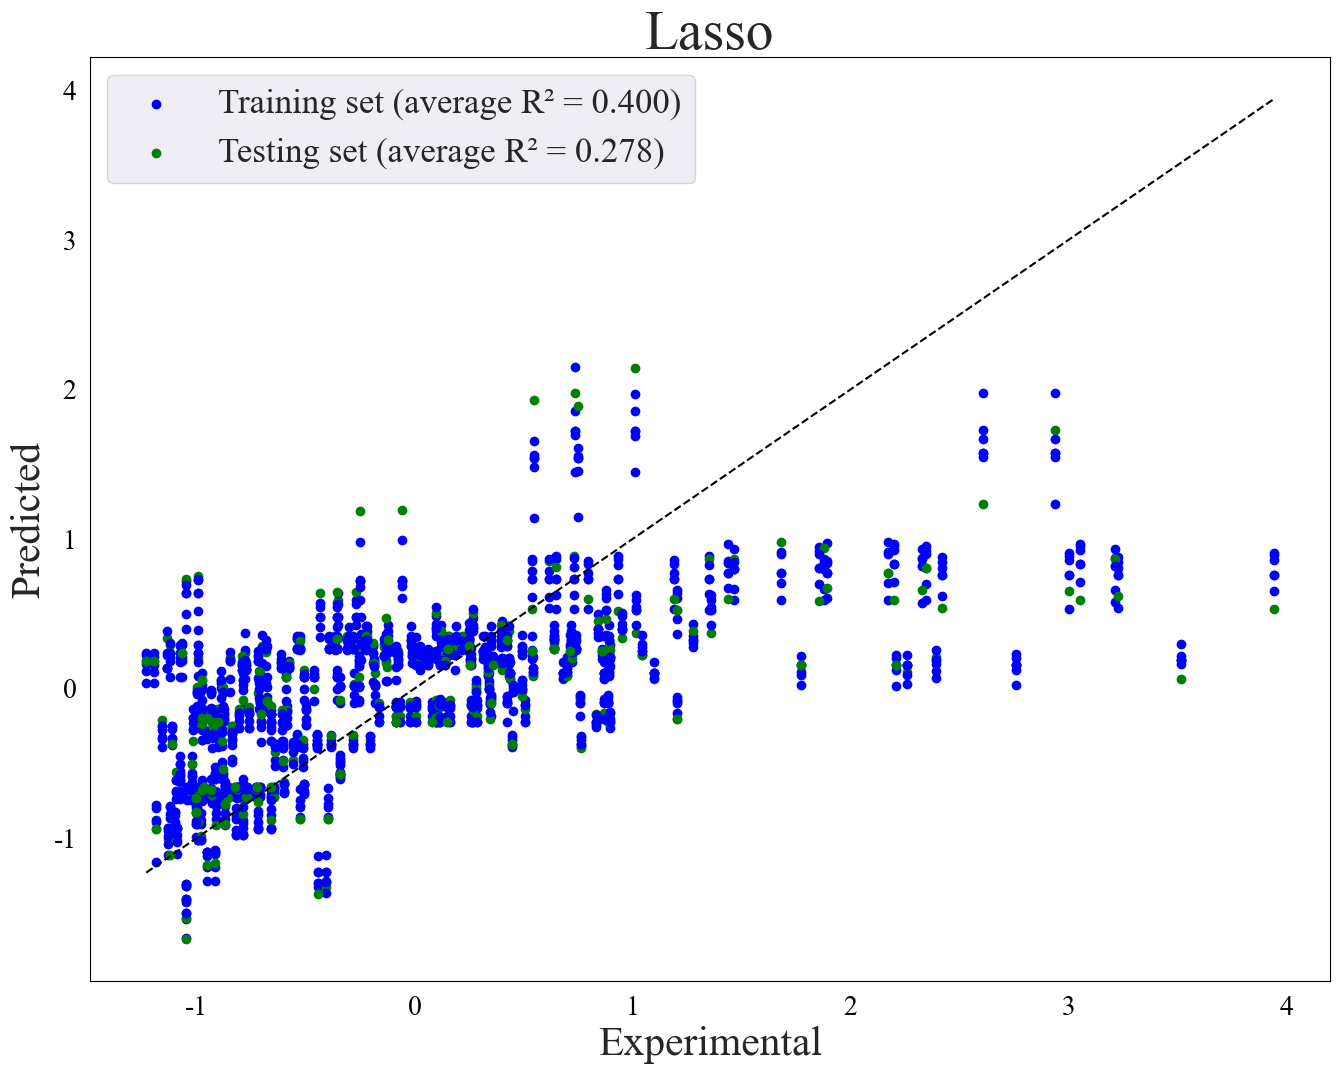

In [34]:
#dingwei
r2_train_EN = []
r2_test_EN = []
mae_train_EN = []
mae_test_EN = []
mse_train_EN = []
mse_test_EN = []
mape_train_EN = []
mape_test_EN = []
# 用于存储每个样本的预测值
y_test_EN_all = []
y_train_EN_all = []
predictions_EN = np.zeros(y_new.shape).reshape(-1,1)
plt.figure(figsize=(16, 12),facecolor='none')

kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
for idx_train, idx_test in kf.split(X_new):
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    # 使用 Optuna 进行优化
    # EN_model=ElasticNet(**study_EN.best_params)
    EN_model=Lasso(**study_EN.best_params)

    EN_model.fit(X_train, y_train)
    y_test_pred_EN= EN_model.predict(X_test)
    y_train_pred_EN= EN_model.predict(X_train)
    EN_train_r2=r2_score(y_train,y_train_pred_EN)
    EN_test_r2=r2_score(y_test,y_test_pred_EN)
    EN_train_mae=mean_absolute_error(y_train, y_train_pred_EN)
    EN_test_mae=mean_absolute_error(y_test, y_test_pred_EN)
    EN_train_mse=mean_squared_error(y_train, y_train_pred_EN)
    EN_test_mse=mean_squared_error(y_test, y_test_pred_EN)
    EN_train_mape=mean_absolute_percentage_error(y_train,y_train_pred_EN)
    EN_test_mape=mean_absolute_percentage_error(y_test,y_test_pred_EN)

    mape_train_EN.append(EN_train_mape)
    mape_test_EN.append(EN_test_mape)
   # 将预测值保存到对应的位置
    # predictions[idx_train] = y_train_pred1.reshape(-1,1)
    predictions_EN[idx_test] = y_test_pred_EN.reshape(-1,1)
    r2_train_EN.append(EN_train_r2)
    r2_test_EN.append(EN_test_r2)
    mae_train_EN.append(EN_train_mae)
    mae_test_EN.append(EN_test_mae)
    mse_train_EN.append(EN_train_mse)
    mse_test_EN.append(EN_test_mse)

    y_test_EN_all.extend(y_test)
    y_train_EN_all.extend(y_test_pred_t1)

    # 实际值与预测值的散点图
    plt.scatter(y_train, y_train_pred_EN,c = 'b')
    plt.scatter(y_test, y_test_pred_EN ,c = 'g')
    fold +=1

plt.scatter(y_train, y_train_pred_EN,c = 'b', label=f'Training set (average R² = {sum(r2_train_EN) / len(r2_train_EN):.3f})')
plt.scatter(y_test, y_test_pred_EN,c = 'g' ,label=f'Testing set (average R² = {sum(r2_test_EN) / len(r2_test_EN):.3f})')

# 确定对角线的起止点
min_val = min(y_new)
max_val = max(y_new)
plt.rcParams['axes.unicode_minus'] = False

# 添加对角线，表示完美预测
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

# 获取当前坐标轴
ax = plt.gca()

#隐藏右边和上边的边框
ax.spines['right'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# 设置坐标轴刻度样式
ax.tick_params(axis='both',       # 'x', 'y', 或 'both'
               which='major',     # 'both', 'major', 或 'minor'
               color='black',    # 刻度线的颜色
               labelcolor='black',
               direction = 'out',
                length = 6,       # 刻度线的长度
                width = 5,  # 刻度线颜色
                labelsize = 20  # 标签字体大小
               ) # 刻度标签的颜色

# 设置坐标轴背景颜色
ax.set_facecolor('none')
# 添加图例和标签
plt.grid(False)
plt.xlabel('Experimental',fontsize = 30)
plt.ylabel('Predicted',fontsize = 30)
plt.title('Lasso',fontsize = 40)
plt.legend(fontsize = 25)
plt.savefig('完美曲线_aveg_Lasso_01.png',dpi=1000)
# 显示图表
plt.show()


In [205]:
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=k_num, shuffle=True, random_state=34)
for idx_train, idx_test in kf.split(X_new):
    X_train, X_test = X_new.iloc[idx_train], X_new.iloc[idx_test]
    y_train, y_test = y_new[idx_train], y_new[idx_test]

    # 使用 Optuna 进行优化
    EN_model=LinearRegression()

    EN_model.fit(X_train, y_train)
    y_test_pred_EN= EN_model.predict(X_test)
    y_train_pred_EN= EN_model.predict(X_train)
    EN_train_r2=r2_score(y_train,y_train_pred_EN)
    EN_test_r2=r2_score(y_test,y_test_pred_EN)
    EN_train_mae=mean_absolute_error(y_train, y_train_pred_EN)
    EN_test_mae=mean_absolute_error(y_test, y_test_pred_EN)
    EN_train_mse=mean_squared_error(y_train, y_train_pred_EN)
    EN_test_mse=mean_squared_error(y_test, y_test_pred_EN)

   # 将预测值保存到对应的位置
    # predictions[idx_train] = y_train_pred1.reshape(-1,1)
    predictions_EN[idx_test] = y_test_pred_EN.reshape(-1,1)
    r2_train_EN.append(EN_train_r2)
    r2_test_EN.append(EN_test_r2)
    mae_train_EN.append(EN_train_mae)
    mae_test_EN.append(EN_test_mae)
    mse_train_EN.append(EN_train_mse)
    mse_test_EN.append(EN_test_mse)

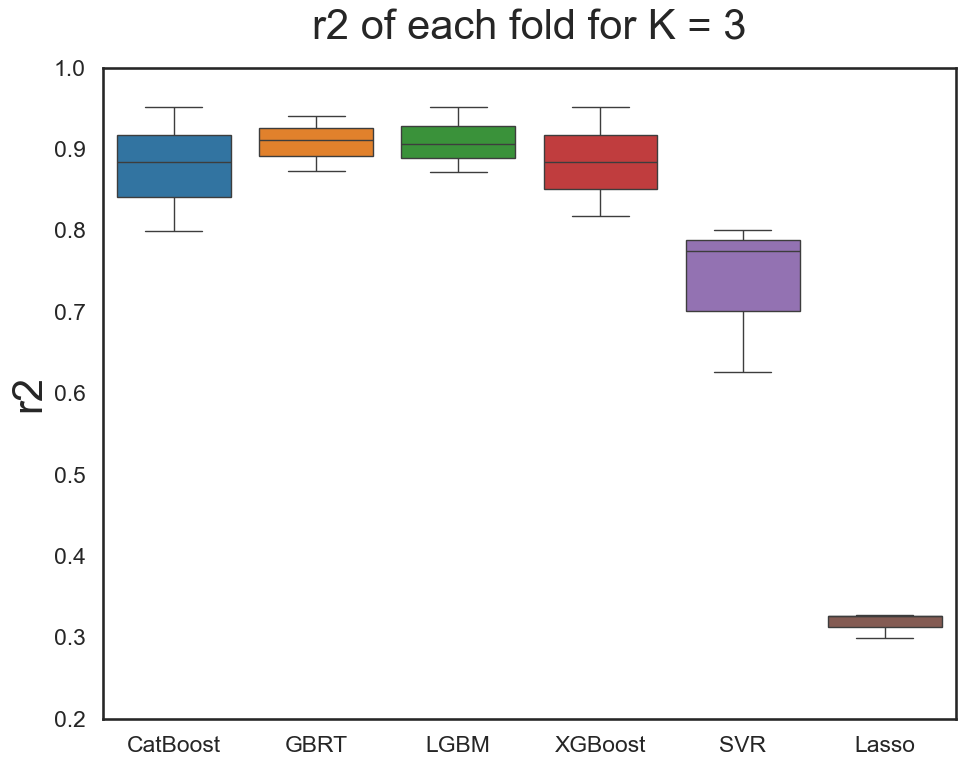

In [475]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'CatBoost':  r2_test_cat,  # 示例数据
    'GBRT': r2_test_gb,
    'LGBM':r2_test_lgb,
    'XGBoost':  r2_test_xgb,
    'SVR': r2_test_SVR,
    'Lasso': r2_test_EN

}
r2_test = pd.DataFrame(data)

# 设置图形样式
plt.figure(figsize=(10, 8))
sns.set_style("white")  # 白色背景
sns.set_context("talk") # 调整字体大小

# 绘制水平箱线图
ax = sns.boxplot(
    data=r2_test,
    orient="v",
    order=['CatBoost',  # 示例数据
    'GBRT',
    'LGBM',
    'XGBoost',
    'SVR',
    'Lasso']  # 控制算法显示顺序
)

# 添加标题和标签
plt.title("r2 of each fold for K = 3",fontsize=30, pad=20)
plt.ylabel("r2",fontsize=30)
plt.ylim(0.20, 1.00)  # 根据原图坐标轴范围设置

# 添加底部注释
# plt.text(
#     x=0.5, y=-0.15,
#     s="Fig. 6. Range in accuracy for each fold for K = 10",
#     ha='center', va='center', transform=ax.transAxes,
#     fontsize=10
# )

plt.tight_layout()
# 如果需要保存图片可添加：
plt.savefig("3-fold_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()



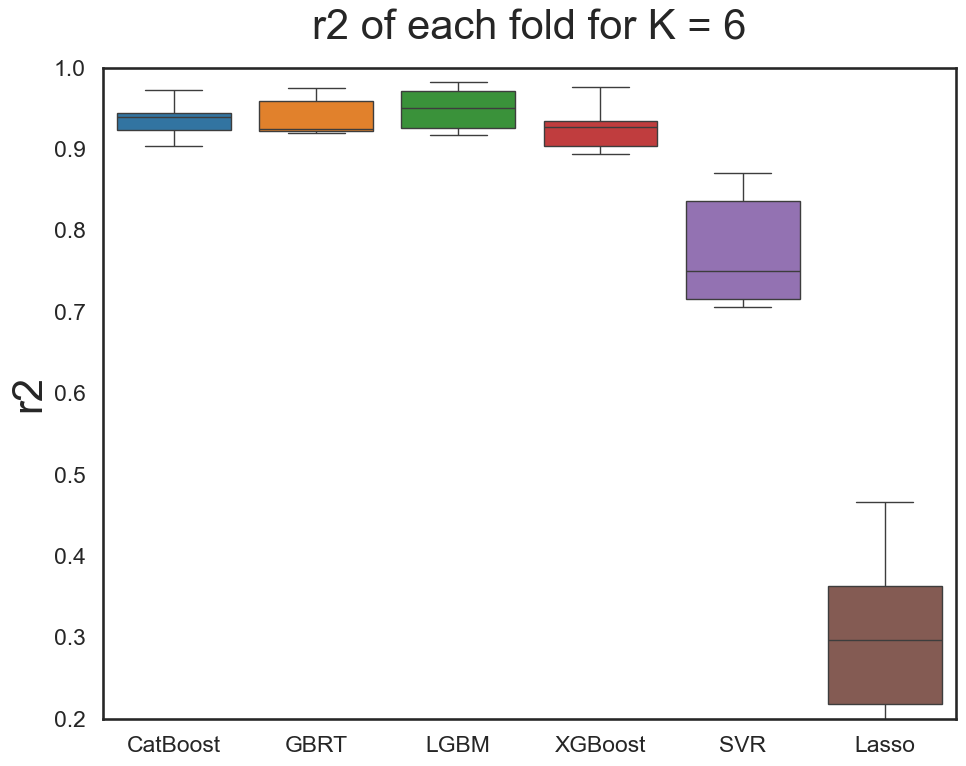

In [489]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'CatBoost':  r2_test_cat,  # 示例数据
    'GBRT': r2_test_gb,
    'LGBM':r2_test_lgb,
    'XGBoost':  r2_test_xgb,
    'SVR': r2_test_SVR,
    'Lasso': r2_test_EN

}
r2_test = pd.DataFrame(data)

# 设置图形样式
plt.figure(figsize=(10, 8))
sns.set_style("white")  # 白色背景
sns.set_context("talk") # 调整字体大小

# 绘制水平箱线图
ax = sns.boxplot(
    data=r2_test,
    orient="v",
    order=['CatBoost',  # 示例数据
    'GBRT',
    'LGBM',
    'XGBoost',
    'SVR',
    'Lasso']  # 控制算法显示顺序
)

# 添加标题和标签
plt.title("r2 of each fold for K = 6",fontsize=30, pad=20)
plt.ylabel("r2",fontsize=30)
plt.ylim(0.20, 1.00)  # 根据原图坐标轴范围设置


plt.tight_layout()
# 如果需要保存图片可添加：
plt.savefig("6-fold_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()



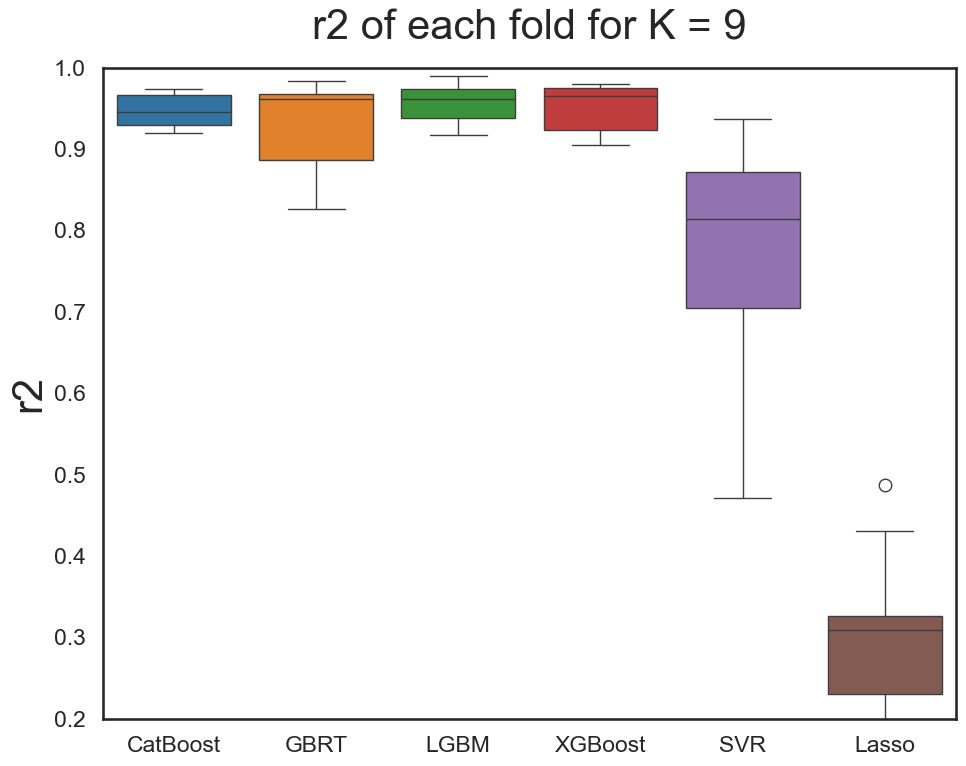

In [503]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = {
    'CatBoost':  r2_test_cat,  # 示例数据
    'GBRT': r2_test_gb,
    'LGBM':r2_test_lgb,
    'XGBoost':  r2_test_xgb,
    'SVR': r2_test_SVR,
    'Lasso': r2_test_EN

}
r2_test = pd.DataFrame(data)

# 设置图形样式
plt.figure(figsize=(10, 8))
sns.set_style("white")  # 白色背景
sns.set_context("talk") # 调整字体大小

# 绘制水平箱线图
ax = sns.boxplot(
    data=r2_test,
    orient="v",

    order=['CatBoost',  # 示例数据
    'GBRT',
    'LGBM',
    'XGBoost',
    'SVR',
    'Lasso']  # 控制算法显示顺序
)

# 添加标题和标签
plt.title("r2 of each fold for K = 9",fontsize=30, pad=20)
plt.ylabel("r2",fontsize=30)
plt.ylim(0.20, 1.00)  # 根据原图坐标轴范围设置

plt.tight_layout()
# 如果需要保存图片可添加：
plt.savefig("9-fold_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()
